In [1]:
from manim import *
from matplotlib.pyplot import tight_layout

from manim_custom import *
from manim_mobject_svg import *
from manim_custom.models import BinaryTree

quality = "ql"
config['background_color'] = WHITE

In [2]:
import openseespy.opensees as ops
import numpy as np


def analyze_truss_with_opensees(nodes, connectivity_matrix, supports, loads, A_list, E_list):
    """
    Parameters:
        nodes: np.array of shape (n_nodes, 3)
        connectivity_matrix: np.array of shape (n_elements, 2)
        supports: dict {node_index: (fix_x, fix_y)}
        loads: dict {node_index: [Fx, Fy]}
        A_list: list of cross-sectional areas (length = n_elements)
        E_list: list of Young's moduli (length = n_elements)

    Returns:
        displacements: dict {node_index: [ux, uy]}
    """

    ops.wipe()
    ops.model('basic', '-ndm', 2, '-ndf', 2)

    # Create nodes
    for i, (x, y, _) in enumerate(nodes):
        ops.node(i, x, y)

    # Supports
    for node_id, (fix_x, fix_y) in supports.items():
        ops.fix(node_id, int(fix_x), int(fix_y))

    # Define elements and materials
    for i, (ni, nj) in enumerate(connectivity_matrix):
        E = E_list[i]
        A = A_list[i]
        ops.uniaxialMaterial("Elastic", i, E)
        ops.element("truss", i, int(ni), int(nj), A, i)

    # Apply loads
    ops.timeSeries("Linear", 1)
    ops.pattern("Plain", 1, 1)
    for node_id, (Fx, Fy) in loads.items():
        ops.load(node_id, Fx, Fy)

    # Static analysis
    ops.system("SparseGeneral")
    ops.numberer("RCM")
    ops.constraints("Plain")
    ops.integrator("LoadControl", 1.0)
    ops.algorithm("Linear")
    ops.analysis("Static")
    ops.analyze(1)

    # Get displacements
    displacements = np.array([
        [ops.nodeDisp(i, 1), ops.nodeDisp(i, 2)]
        for i in range(len(nodes))
    ])

    forces = np.array([ops.eleResponse(i, 'axialForce')[0] for i in range(len(connectivity_matrix))])

    return displacements, forces

Manim Community v0.19.0

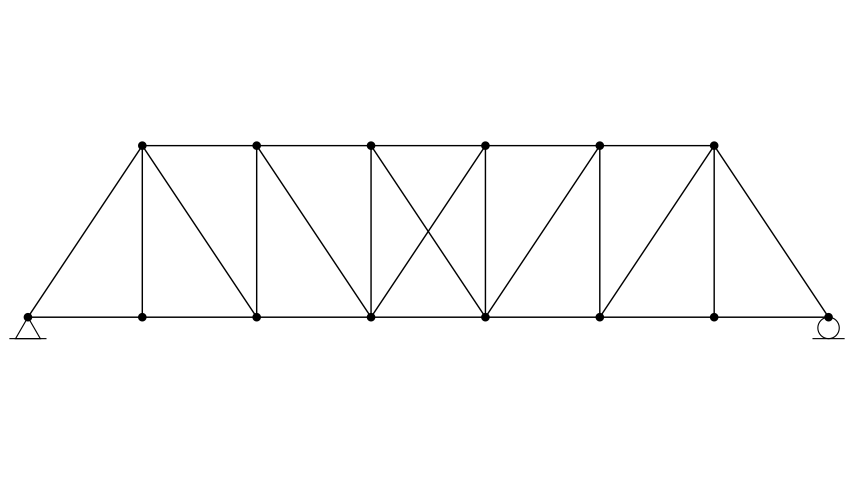

In [3]:
nodes = np.array([(0, 0, 0), (4, 0, 0), (8, 0, 0), (12, 0, 0),
                  (16, 0, 0), (20, 0, 0), (24, 0, 0), (28, 0, 0),
                  (4, 6, 0), (8, 6, 0), (12, 6, 0),
                  (16, 6, 0), (20, 6, 0), (24, 6, 0)], dtype=float)

supports = {0: (True, True), 7: (False, True)}
connectivity_matrix = np.array([(0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 6), (6, 7), (7, 13),
                                (8, 9), (9, 10), (10, 11), (11, 12), (12, 13), (8, 0),
                                (1, 8), (2, 9), (3, 10), (4, 11), (5, 12), (6, 13),
                                (2, 8), (3, 9), (4, 10), (3, 11), (4, 12), (5, 13)])

A = [.1] * len(connectivity_matrix)
E = [210e9] * len(connectivity_matrix)

loads = {k: (0., -1000.e3) for k in range(1, 7)}

u, N = analyze_truss_with_opensees(nodes, connectivity_matrix, supports, loads, A, E)


class ExampleTruss(MovingCameraScene):
    def __init__(self, **kargs):
        super().__init__(**kargs)
        self.camera.resize_frame_shape(0)
        self.camera.frame.scale(2.1)
        self.camera.frame.move_to(ORIGIN)

    def construct(self):
        g = Truss(nodes=nodes,
                  connectivity_matrix=connectivity_matrix,
                  supports=supports,
                  display_loads=False,
                  loads=loads,
                  displacements=u,
                  member_style={'stroke_width': 5},
                  node_style={'radius': .15},
                  support_style={'height': .75},
                  deformed_style={'dash_length': .25})

        g.move_to(ORIGIN)
        g.update()
        self.add(g)

        all_group = get_all_vmobjects(self)
        all_group.center()
        path = "img/03-real_truss_example_schematics.svg"
        all_group.to_svg(path, crop=True)

%manim --format png -ql -v WARNING ExampleTruss

Manim Community v0.19.0

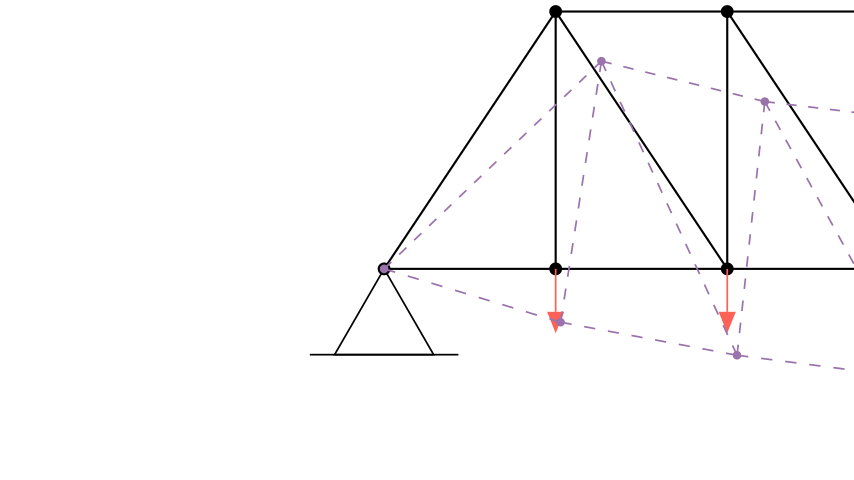

In [19]:
class DeformedStructure(MovingCameraScene):
    def __init__(self, **kargs):
        super().__init__(**kargs)
        self.camera.resize_frame_shape(0)
        self.camera.frame.scale(1.4)

    def construct(self):
        g = Truss(nodes=nodes,
                  connectivity_matrix=connectivity_matrix,
                  supports=supports,
                  display_loads=True,
                  loads=loads,
                  displacements=u,
                  member_style={'stroke_width': 5},
                  node_style={'radius': .15},
                  deformed_node_style={'radius': .1},
                  support_style={'height': 2},
                  deformed_style={'dash_length': .25, 'stroke_width': 4})
        g.move_to(ORIGIN)
        g.overlap_deformation(scale=300)
        g.update()
        self.camera.frame.move_to(VGroup([g.nodes[i] for i in (0, 1, 8)]).get_center())
        self.camera.frame.shift(DOWN * 2).shift(1 * LEFT)
        self.add(g)

        all_group = get_all_vmobjects(self)
        all_group.center()
        path = "img/03-deformed_structure.svg"
        all_group.to_svg(path, crop=True)

%manim --format png -ql -v WARNING DeformedStructure

Manim Community v0.19.0

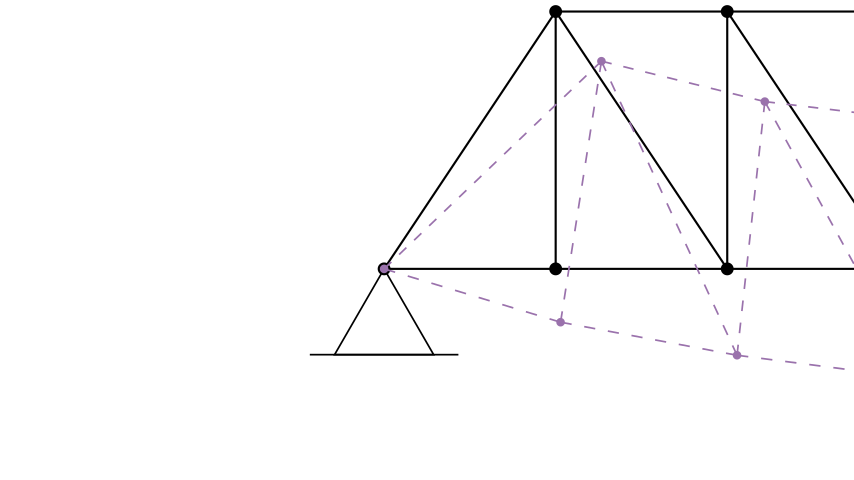

In [20]:
class PinnedSupportMove(MovingCameraScene):
    def __init__(self, **kargs):
        super().__init__(**kargs)
        self.camera.resize_frame_shape(0)
        self.camera.frame.scale(1.4)

    def construct(self):
        g = Truss(nodes=nodes,
                  connectivity_matrix=connectivity_matrix,
                  supports=supports,
                  display_loads=False,
                  loads=loads,
                  displacements=u,
                  member_style={'stroke_width': 5},
                  node_style={'radius': .15},
                  deformed_node_style={'radius': .1},
                  support_style={'height': 2},
                  deformed_style={'dash_length': .25, 'stroke_width': 4})
        g.move_to(ORIGIN)
        g.overlap_deformation(scale=300)
        g.update()
        self.camera.frame.move_to(VGroup([g.nodes[i] for i in (0, 1, 8)]).get_center())
        self.camera.frame.shift(DOWN * 2).shift(1 * LEFT)
        self.add(g)

        all_group = get_all_vmobjects(self)
        all_group.center()
        path = "img/03-pinned_support.svg"
        all_group.to_svg(path, crop=False)

%manim --format png -ql -v WARNING PinnedSupportMove

Manim Community v0.19.0

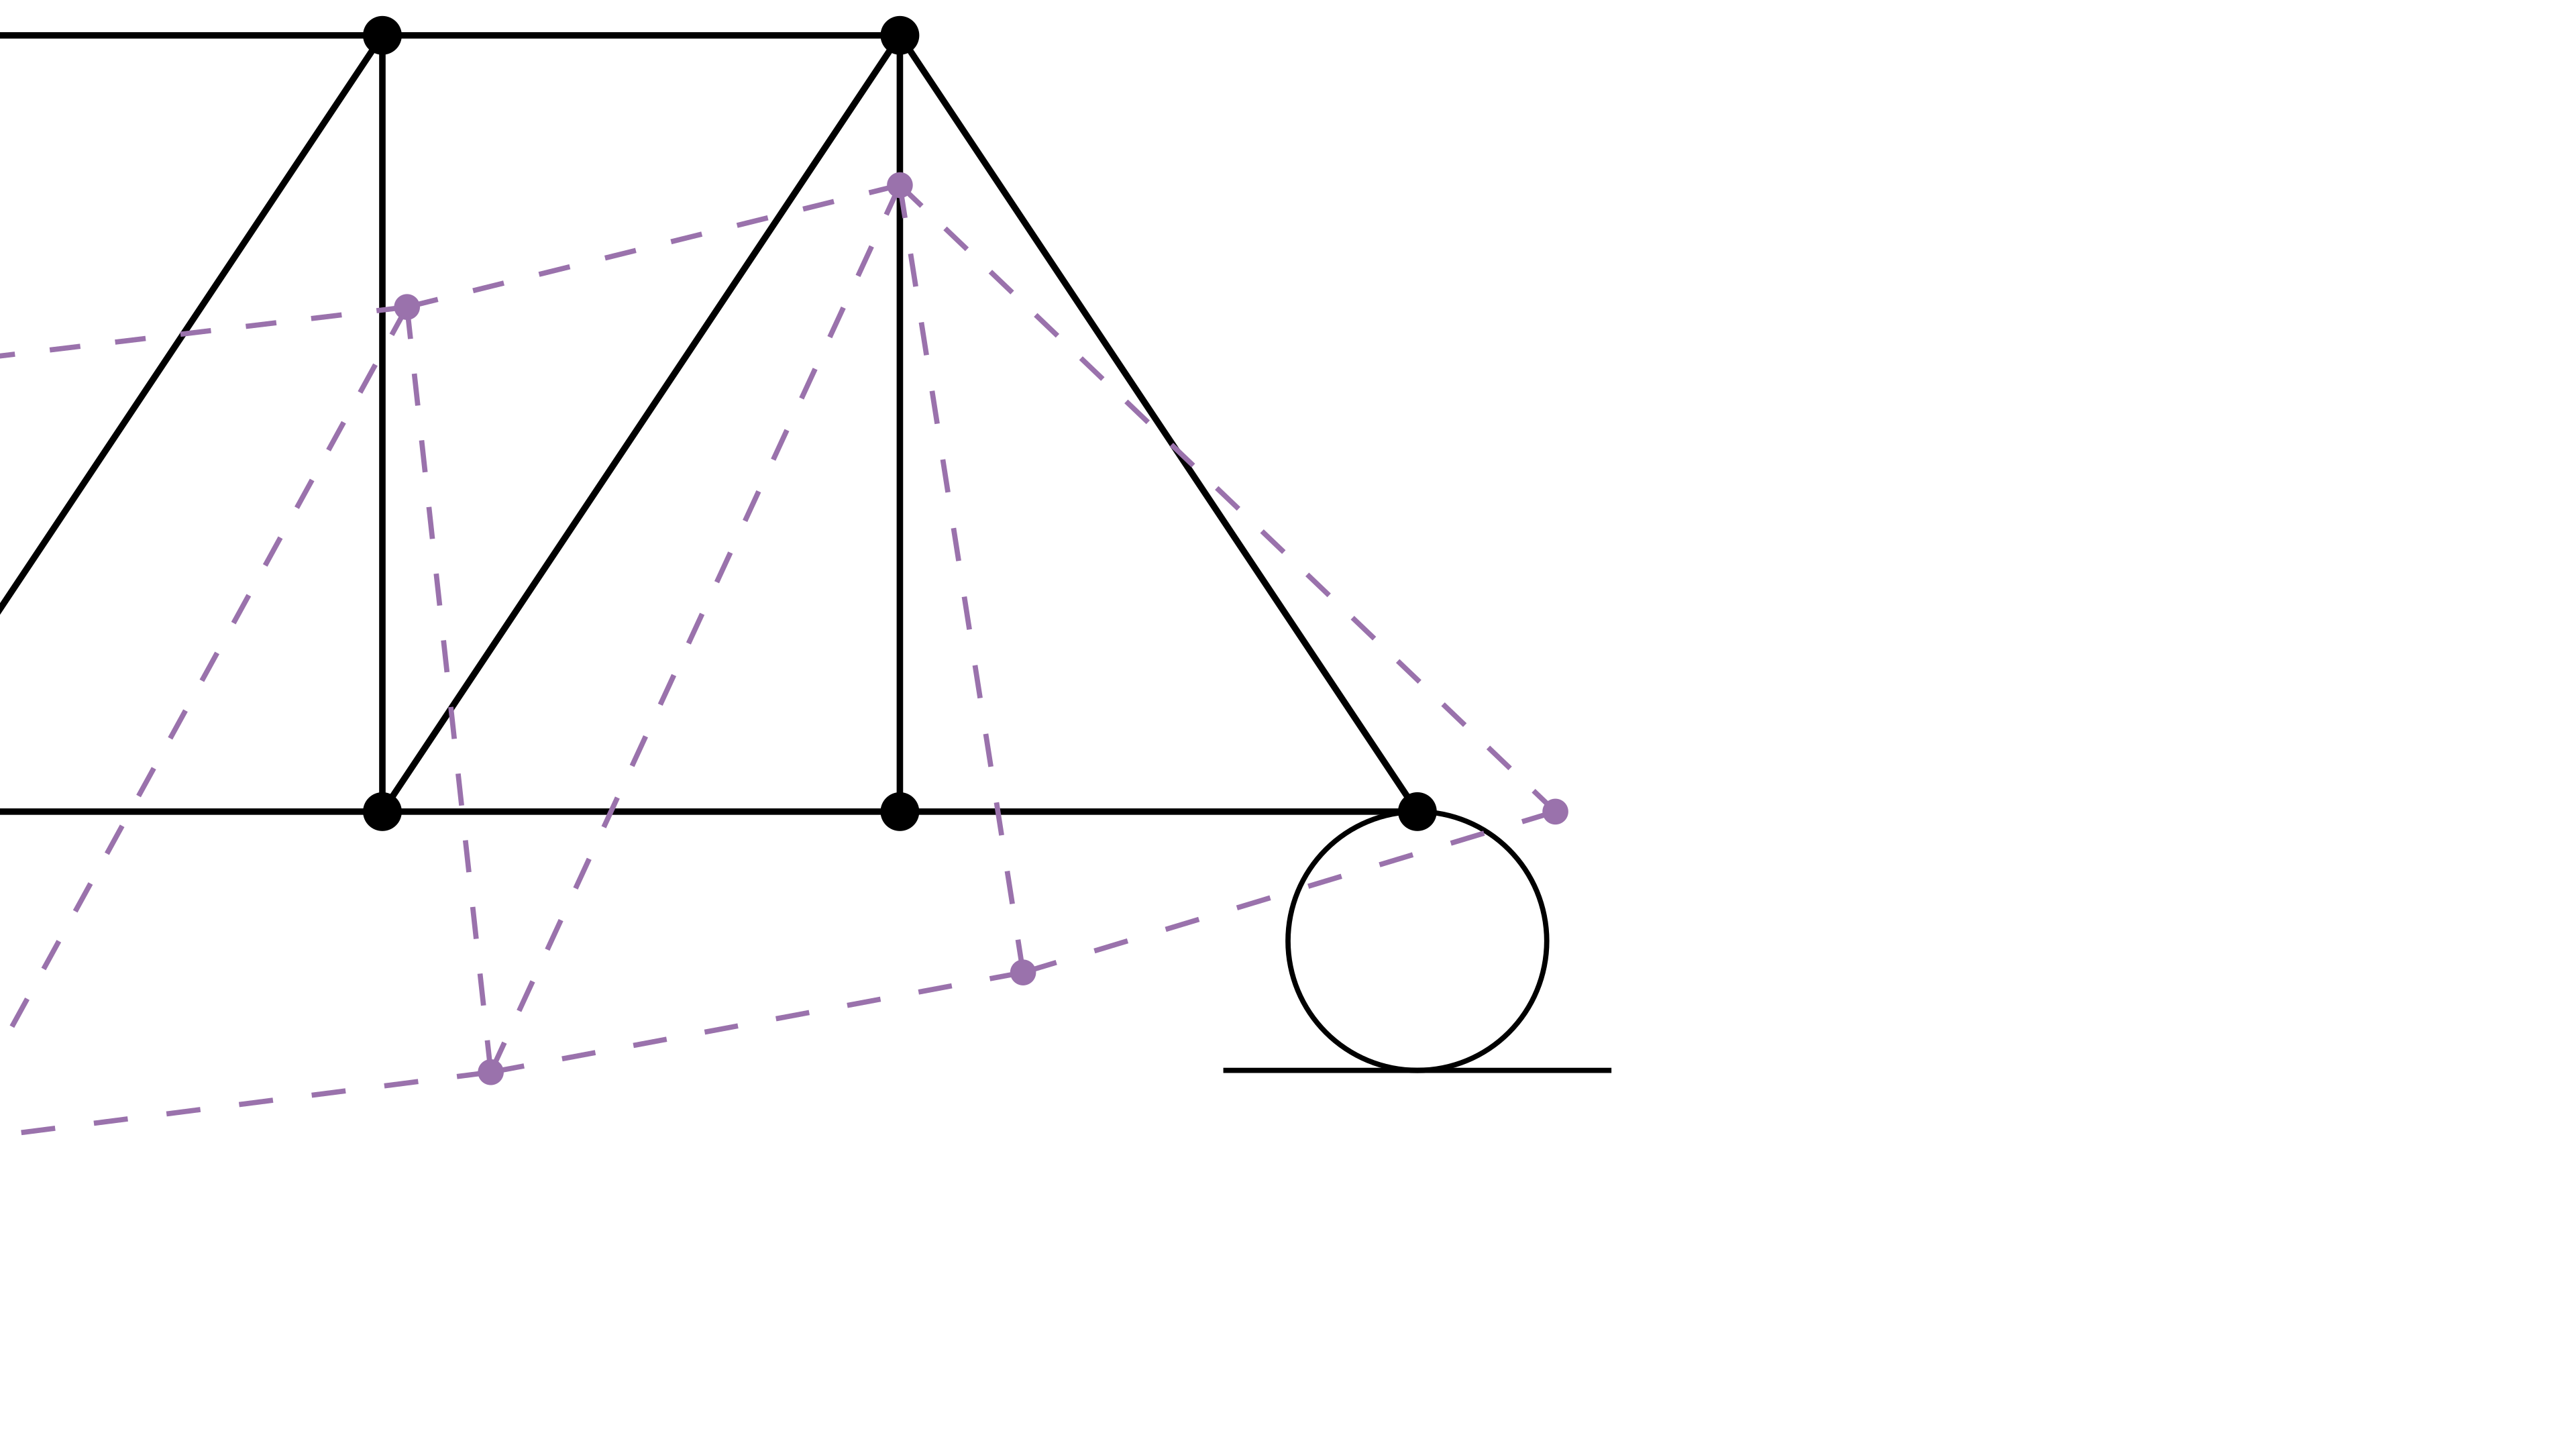

In [21]:
class RollingSupportMove(MovingCameraScene):
    def __init__(self, **kargs):
        super().__init__(**kargs)
        self.camera.resize_frame_shape(0)
        self.camera.frame.scale(1.4)

    def construct(self):
        g = Truss(nodes=nodes,
                  connectivity_matrix=connectivity_matrix,
                  supports=supports,
                  display_loads=False,
                  loads=loads,
                  displacements=u,
                  member_style={'stroke_width': 5},
                  node_style={'radius': .15},
                  deformed_node_style={'radius': .1},
                  support_style={'height': 2},
                  deformed_style={'dash_length': .25})
        g.move_to(ORIGIN)
        g.overlap_deformation(scale=300)
        g.update()
        self.camera.frame.move_to(VGroup([g.nodes[i] for i in (7, 13, 6)]).get_center())
        self.camera.frame.shift(DOWN * 2).shift(1 * RIGHT)
        self.add(g)

        all_group = get_all_vmobjects(self)
        all_group.center()
        path = "img/03-rolling_support.svg"
        all_group.to_svg(path, crop=False)

%manim --format png -qk -v WARNING RollingSupportMove

Manim Community v0.19.0

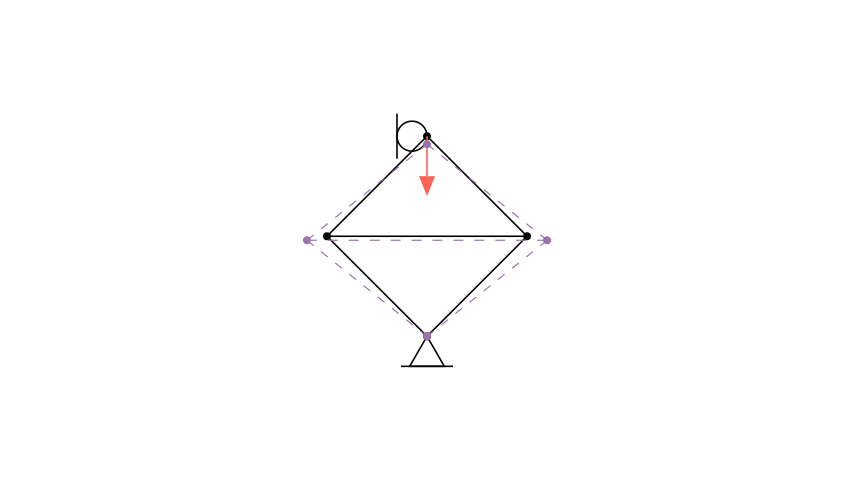

In [22]:
class TriangulatedTruss(MovingCameraScene):
    def __init__(self, **kargs):
        super().__init__(**kargs)
        self.camera.frame.scale(1.5)

    def construct(self):
        nodes = np.array([(0, 0, 0), (2.5, 2.5, 0), (0, 5, 0), (-2.5, 2.5, 0)], dtype=float)
        supports = {0: (True, True), 2: (True, False)}
        connectivity_matrix = np.array([(0, 1), (1, 2), (2, 3), (3, 0), (1, 3)])
        loads = {2: [0., -1000e3]}

        u = np.array([
            [0, 0], [.1, -.02], [0, -.04], [-.1, -.02],
        ])
        g = Truss(nodes=nodes,
                  connectivity_matrix=connectivity_matrix,
                  supports=supports,
                  loads=loads,
                  displacements=u,
                  deformed_node_style={'radius': .1},
                  deformed_style={'stroke_width': 3, 'dash_length': .2},
                  support_style={'height': .75},
                  node_label_offsets=[.4 * UP, .4 * (UP + RIGHT), .4 * UP, .4 * UP],
                  member_label_offsets=[.3 * UP, .3 * UP, .3 * UR, .3 * UL, .4 * RIGHT],
                  )
        g.move_to(ORIGIN)
        g.overlap_deformation(scale=5)
        g.update()

        self.add(g)

        all_group = get_all_vmobjects(self)
        all_group.center()
        path = "img/03-triangulated_truss.svg"
        all_group.to_svg(path, crop=True)

%manim --format png -ql -v WARNING TriangulatedTruss

Manim Community v0.19.0

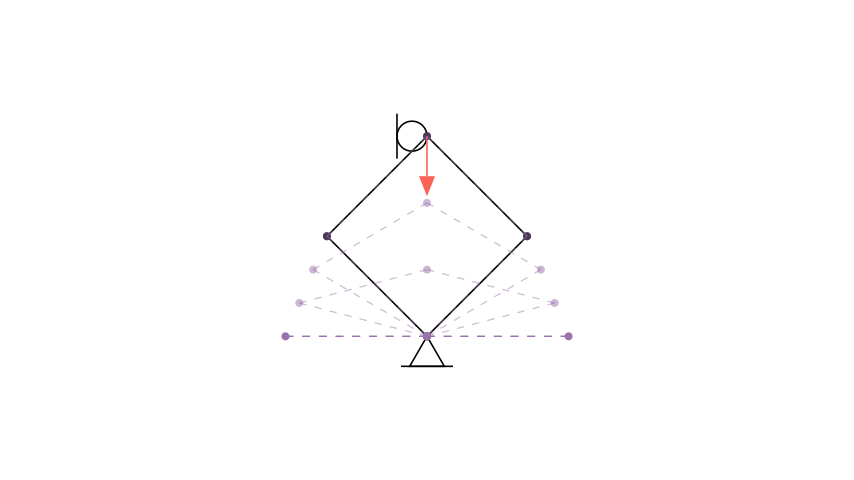

In [23]:
class UntriangulatedTruss(MovingCameraScene):
    def __init__(self, **kargs):
        super().__init__(**kargs)
        self.camera.frame.scale(1.5)

    def construct(self):
        nodes = np.array([(0, 0, 0), (2.5, 2.5, 0), (0, 5, 0), (-2.5, 2.5, 0)], dtype=float)
        supports = {0: (True, True), 2: (True, False)}
        connectivity_matrix = np.array([(0, 1), (1, 2), (2, 3), (3, 0)])
        loads = {2: [0., -1000e3]}

        u = np.array([
            [0, 0], [(2 ** .5 - 1) * 2.5, -2.5], [0, -5], [-(2 ** .5 - 1) * 2.5, -2.5],
        ])

        g = Truss(nodes=nodes,
                  connectivity_matrix=connectivity_matrix,
                  supports=supports,
                  loads=loads,
                  displacements=u,
                  deformed_node_style={'radius': .1},
                  deformed_style={'stroke_width': 3, 'dash_length': .2},
                  support_style={'height': .75},
                  node_label_offsets=[.4 * UP, .4 * (UP + RIGHT), .4 * UP, .4 * UP],
                  member_label_offsets=[.3 * UP, .3 * UP, .3 * UR, .3 * UL, .4 * RIGHT],
                  )
        g.move_to(ORIGIN)

        n = 3
        for i in range(0, n):
            g.overlap_deformation(scale=i * 1 / n)
            g.update()
            vmo_n = g.displaced_nodes
            vmo_m = g.displaced_members
            vmo_n.set_opacity(.5)
            vmo_m.set_opacity(.5)

        g.overlap_deformation(scale=1.)
        self.add(g)

        all_group = get_all_vmobjects(self)
        all_group.center()
        path = "img/03-untriangulated_truss.svg"
        all_group.to_svg(path, crop=True)

%manim --format png -ql -v WARNING UntriangulatedTruss

Manim Community v0.19.0

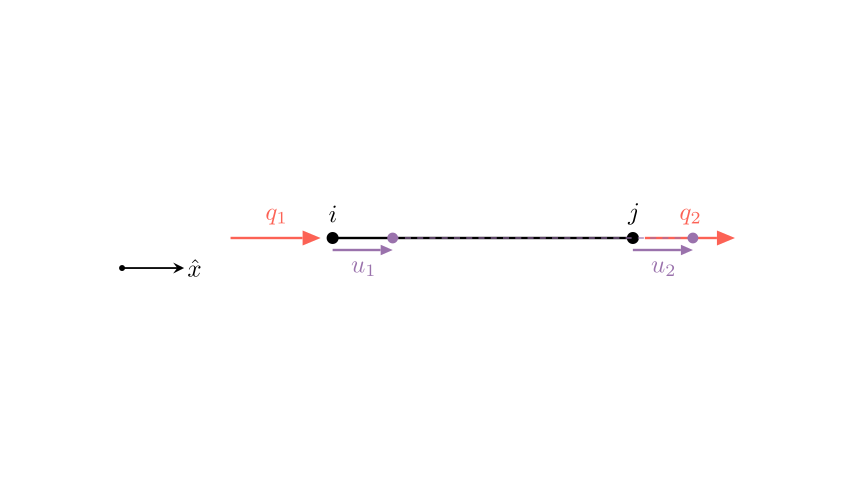

In [24]:
class LocalElement(MovingCameraScene):
    def construct(self):
        font_size = 40
        axis_tip_kwargs = {'tip_shape': StealthTip, 'tip_length': .1, 'tip_width': .05}
        u_tip_kwargs = {'tip_length': .2, 'tip_width': .175}
        q_tip_kwargs = {'tip_length': .3, 'tip_width': .25}
        u_scale = 1
        buff = .1
        g = Truss(nodes=np.array([[0, 0, 0], [5, 0, 0]], dtype=float),
                  connectivity_matrix=[[0, 1]],
                  supports={},
                  displacements=np.array([[1, 0], [1, 0]]),
                  loads={0: [1., 0.], 1: [1., 0.]},
                  tip_style=q_tip_kwargs,
                  node_labels=['$i$', '$j$'],
                  node_label_offsets=[.4 * UP, .4 * UP],
                  node_label_style={'text_class': Tex, 'font_size': font_size},
                  display_node_labels=True,
                  display_load_labels=True,
                  load_labels=[r'$q_1$', r'$q_2$'],
                  load_label_style={'prefix': '', 'suffix': '', 'font_size': font_size},
                  load_label_offsets=[LEFT, RIGHT],
                  deformed_style={'stroke_width': 2, 'dash_length': .1},
                  deformed_node_style={'radius': .09})

        g.move_to(ORIGIN)
        g.overlap_deformation(scale=u_scale)
        g.update()

        arrow1 = (Line(g.nodes[0].get_center(), g.displaced_nodes[0].get_center(), color=PURPLE)
                  .add_tip(**u_tip_kwargs)
                  .shift(.2 * DOWN))
        arrow2 = (Line(g.nodes[1].get_center(), g.displaced_nodes[1].get_center(), color=PURPLE)
                  .add_tip(**u_tip_kwargs)
                  .shift(.2 * DOWN))

        g.loads[0].next_to(g.nodes[0], LEFT, buff=buff)
        g.loads[1].next_to(g.nodes[1], RIGHT, buff=buff)

        g.loads_labels[0].next_to(g.loads[0], UP, buff=.1)
        g.loads_labels[1].next_to(g.loads[1], UP, buff=.1)

        text1 = Tex("$u_1$", color=PURPLE, font_size=font_size).next_to(arrow1, DOWN, buff=.1)
        text2 = Tex("$u_2$", color=PURPLE, font_size=font_size).next_to(arrow2, DOWN, buff=.1)

        axes = VGroup()
        axis = (Line([0., 0., 0.], [1, 0., 0.], color=BLACK, stroke_width=3)
                .add_tip(**axis_tip_kwargs))
        axes.add(axis, Dot(axis.get_start(), color=BLACK, radius=.05))

        text3 = (Tex(r"$\hat{x}$", color=BLACK, font_size=font_size)
                 .next_to(axis, RIGHT, buff=.1))
        axes.add(text3)

        axes.next_to(g.loads[0], LEFT, buff=.5).shift(.5 * DOWN)

        self.add(g, arrow1, arrow2, text1, text2, axis, axes)

        all_group = get_all_vmobjects(self)
        all_group.center()
        path = "img/03-local_element.svg"
        all_group.to_svg(path, crop=True)

%manim --format png -ql -v WARNING LocalElement

In [25]:
f = .1 / 2 ** .5
a = [0, 1, 5]
b = [i for i in range(8) if i not in a]
EA = 525e6
K = EA * np.array([
    [.2 + f, f, -.2, 0, 0, 0, -f, -f],
    [f, f, 0, 0, 0, 0, -f, -f],
    [-.2, 0, .4, 0, -.2, 0, 0, 0],
    [0, 0, 0, .2, 0, 0, 0, -.2],
    [0, 0, -.2, 0, .2 + f, -f, -f, f],
    [0, 0, 0, 0, -f, f, f, -f],
    [-f, -f, 0, 0, -f, f, 2 * f, 0],
    [-f, -f, 0, -.2, f, -f, 0, 2 * (.1 + f)],
])
Kaa = K[a, :][:, a]
Kab = K[a, :][:, b]
Kba = K[b, :][:, a]
Kbb = K[b, :][:, b]

q = np.array([0, 0, 0, -1000e3, 0, 0, 0, 0]).reshape((-1, 1))
qa = q[a]
qb = q[b]

u = np.zeros((len(a) + len(b), 1))
ua = np.zeros((len(a), 1))
ub = np.linalg.solve(Kbb, qb)
u[b] = ub

r = np.zeros((len(a) + len(b), 1))
ra = Kab @ ub - qa
rb = np.zeros((len(b), 1))
r[a] = ra

coordinates = np.array([[0, 0, 0], [5, 0, 0], [10, 0, 0], [5, 5, 0]], dtype=float)
connectivity_matrix = np.array([[0, 1], [1, 2], [2, 3], [3, 0], [3, 1]])
l = np.array([
    [1, 0], [1, 0], [-1, 1], [-1, -1], [0, -1]
], dtype=float)
l /= np.linalg.norm(l, axis=1, keepdims=True)

N = []
for idx, (i, j) in enumerate(connectivity_matrix):
    l_member = l[idx]
    u_i = u[[2 * i, 2 * i + 1]].reshape(-1)
    u_j = u[[2 * j, 2 * j + 1]].reshape(-1)
    L = np.linalg.norm((coordinates[j] - coordinates[i]), axis=0)
    N_member = EA * ((u_j - u_i) @ l_member) / L
    N.append(N_member)

    s = lambda u: rf"\begin{{bmatrix}}{u[0]:.3f}\\{u[1]:.3f}\end{{bmatrix}}"
    print(fr"${idx + 1}$ & ${L:.3f}$ & ${s(l_member)}$ & ${s(u_i)}$ & ${s(u_j)}$ & ${N_member / 1000:.2f}$\\\hline")
N = np.array(N)

u_fem, N_fem = analyze_truss_with_opensees(coordinates, connectivity_matrix,
                                           {0: (True, True), 2: (False, True)},
                                           {1: (0., -1000.e3)},
                                           [1 for _ in range(5)],
                                           [525e6 for _ in range(5)])

$1$ & $5.000$ & $\begin{bmatrix}1.000\\0.000\end{bmatrix}$ & $\begin{bmatrix}0.000\\0.000\end{bmatrix}$ & $\begin{bmatrix}0.005\\-0.028\end{bmatrix}$ & $500.00$\\\hline
$2$ & $5.000$ & $\begin{bmatrix}1.000\\0.000\end{bmatrix}$ & $\begin{bmatrix}0.005\\-0.028\end{bmatrix}$ & $\begin{bmatrix}0.010\\0.000\end{bmatrix}$ & $500.00$\\\hline
$3$ & $7.071$ & $\begin{bmatrix}-0.707\\0.707\end{bmatrix}$ & $\begin{bmatrix}0.010\\0.000\end{bmatrix}$ & $\begin{bmatrix}0.005\\-0.018\end{bmatrix}$ & $-707.11$\\\hline
$4$ & $7.071$ & $\begin{bmatrix}-0.707\\-0.707\end{bmatrix}$ & $\begin{bmatrix}0.005\\-0.018\end{bmatrix}$ & $\begin{bmatrix}0.000\\0.000\end{bmatrix}$ & $-707.11$\\\hline
$5$ & $5.000$ & $\begin{bmatrix}0.000\\-1.000\end{bmatrix}$ & $\begin{bmatrix}0.005\\-0.018\end{bmatrix}$ & $\begin{bmatrix}0.005\\-0.028\end{bmatrix}$ & $1000.00$\\\hline


Manim Community v0.19.0

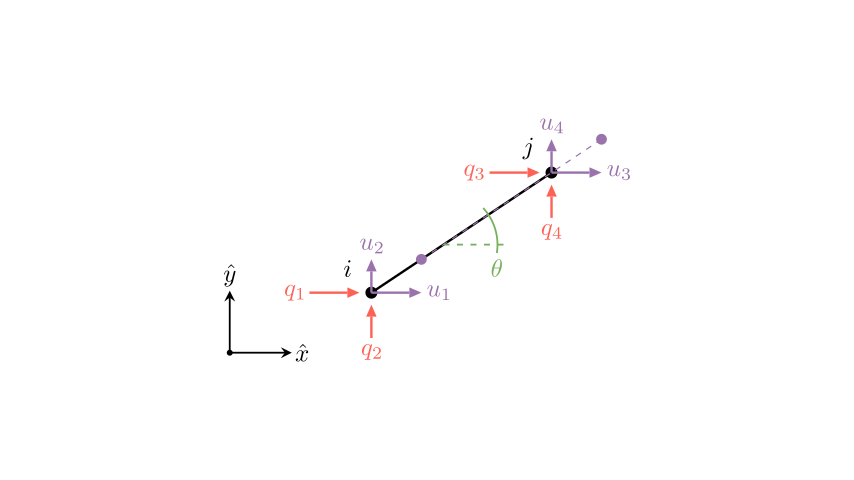

In [26]:


class GlobalElement(MovingCameraScene):
    def construct(self):
        font_size = 40
        axis_tip_kwargs = {'tip_shape': StealthTip, 'tip_length': .1, 'tip_width': .05}
        u_tip_kwargs = {'tip_length': .2, 'tip_width': .175}
        q_tip_kwargs = {'tip_length': .3, 'tip_width': .25}

        u = np.array([[3., 2], [3., 2]], dtype=float)
        u /= np.linalg.norm(u, axis=1)
        u_scale = 1
        u_color = PURPLE
        q_color = RED
        buff = .1
        g = Truss(nodes=np.array([[0, 0, 0], [3, 2, 0]], dtype=float),
                  connectivity_matrix=[[0, 1]],
                  supports={},
                  displacements=u,
                  loads={},
                  tip_style=q_tip_kwargs,
                  node_labels=['$i$', '$j$'],
                  node_label_offsets=[.4 * UL, .4 * UL],
                  node_label_style={'text_class': Tex, 'font_size': font_size},
                  display_node_labels=True,
                  display_load_labels=False,
                  deformed_style={'stroke_width': 2, 'dash_length': .1},
                  deformed_node_style={'radius': .09})

        #g.move_to(ORIGIN)
        g.overlap_deformation(scale=u_scale)
        g.update()

        # Load
        q_1 = VGroup()
        q_1.add(Line([0, 0, 0], u[0, 0] * LEFT * u_scale, color=q_color)
                .add_tip(at_start=True, **u_tip_kwargs)
                .next_to(g.nodes[0], LEFT, buff=buff))
        q_1.add(Line([0, 0, 0], u[0, 1] * DOWN * u_scale, color=q_color)
                .add_tip(at_start=True, **u_tip_kwargs)
                .next_to(g.nodes[0], DOWN, buff=buff))
        q_1.add(Tex(r'$q_1$', font_size=font_size, color=q_color).next_to(q_1[0], LEFT, buff=.1))
        q_1.add(Tex(r'$q_2$', font_size=font_size, color=q_color).next_to(q_1[1], DOWN, buff=.1))

        q_2 = VGroup()
        q_2.add(Line([0, 0, 0], u[1, 0] * LEFT * u_scale, color=q_color)
                .add_tip(at_start=True, **u_tip_kwargs)
                .next_to(g.nodes[1], LEFT, buff=buff))
        q_2.add(Line([0, 0, 0], u[1, 1] * DOWN * u_scale, color=q_color)
                .add_tip(at_start=True, **u_tip_kwargs)
                .next_to(g.nodes[1], DOWN, buff=buff))
        q_2.add(Tex(r'$q_3$', font_size=font_size, color=q_color).next_to(q_2[0], LEFT, buff=.1))
        q_2.add(Tex(r'$q_4$', font_size=font_size, color=q_color).next_to(q_2[1], DOWN, buff=.1))

        # Deformation
        u_1 = VGroup()
        u_1.add(Line([0, 0, 0], u[0, 0] * RIGHT * u_scale, color=u_color)
                .add_tip(**u_tip_kwargs))
        u_1.add(Line([0, 0, 0], u[0, 1] * UP * u_scale, color=u_color)
                .add_tip(**u_tip_kwargs))
        u_1.add(Tex(r'$u_1$', font_size=font_size, color=u_color).next_to(u_1[0], RIGHT, buff=.1))
        u_1.add(Tex(r'$u_2$', font_size=font_size, color=u_color).next_to(u_1[1], UP, buff=.1))
        u_1.shift(g.nodes[0].get_center() - u_1[0].get_start())

        u_2 = VGroup()
        u_2.add(Line([0, 0, 0], u[0, 0] * RIGHT * u_scale, color=u_color)
                .add_tip(**u_tip_kwargs))
        u_2.add(Line([0, 0, 0], u[0, 1] * UP * u_scale, color=u_color)
                .add_tip(**u_tip_kwargs))
        u_2.add(Tex(r'$u_3$', font_size=font_size, color=u_color).next_to(u_2[0], RIGHT, buff=.1))
        u_2.add(Tex(r'$u_4$', font_size=font_size, color=u_color).next_to(u_2[1], UP, buff=.1))
        u_2.shift(g.nodes[1].get_center() - u_2[0].get_start())

        axes = VGroup()
        x_axis = (Line([0., 0., 0.], [1, 0., 0.], color=BLACK, stroke_width=3)
                  .add_tip(**axis_tip_kwargs))
        y_axis = (Line([0., 0., 0.], [0., 1, 0.], color=BLACK, stroke_width=3)
                  .add_tip(**axis_tip_kwargs))

        axes.add(x_axis, y_axis, Dot(x_axis.get_start(), color=BLACK, radius=.05))

        text3 = (Tex(r"$\hat{x}$", color=BLACK, font_size=font_size)
                 .next_to(x_axis, RIGHT, buff=.1))
        text4 = (Tex(r"$\hat{y}$", color=BLACK, font_size=font_size)
                 .next_to(y_axis, UP, buff=.1))

        axes.add(text3, text4)

        axes.align_to(g, LEFT).shift(2 * LEFT + 1 * DOWN)

        angle = VGroup()
        angle.add(DashedLine([0, 0, 0], [1, 0, 0], color=GREEN_D, stroke_width=3, dash_length=.1))
        arc_angle = np.acos(np.dot(u[0], [1, 0]))
        angle.add(Arc(.9, -PI / 20, arc_angle + 2 * PI / 20, color=GREEN_D, stroke_width=3))
        angle.shift(g.members[0].get_center() - angle[0].get_left())
        angle.shift(.2 * (g.members[0].get_start() - g.members[0].get_center()))
        angle.add(Tex(r"$\theta$", color=GREEN_D, font_size=font_size)
                  .next_to(angle[1].get_start(), DOWN, .1))

        self.add(g, q_1, q_2, u_1, u_2, axes, angle)

        all_group = get_all_vmobjects(self)
        all_group.center()
        path = "img/03-global_element.svg"
        all_group.to_svg(path, crop=True)

%manim --format png -ql -v WARNING GlobalElement

In [27]:
K = 525e6 * np.array(
    [
        [.4, 0, -.2, 0, 0],
        [0, .2, 0, 0, -.2],
        [-.2, 0, .2 + .1 / 2 ** .5, -.1 / 2 ** .5, .1 / 2 ** .5],
        [0, 0, -.1 / 2 ** .5, .2 / 2 ** .5, 0],
        [0, -.2, .1 / 2 ** .5, 0, .2 + .2 / 2 ** .5]
    ]
)
q = np.array([0, -1000e3, 0, 0, 0]).T

np.linalg.solve(K, q) * 1000

array([  4.76190476, -27.75441488,   9.52380952,   4.76190476,
       -18.23060536])

Manim Community v0.19.0

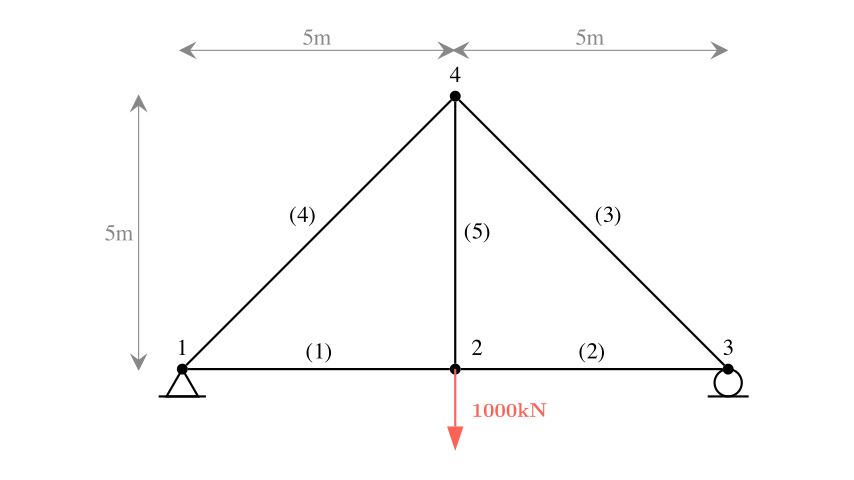

In [28]:

class ExampleTruss(MovingCameraScene):
    def __init__(self, **kargs):
        super().__init__(**kargs)
        self.camera.frame.scale(1.1)
        self.camera.frame.move_to(ORIGIN)

    def construct(self):
        nodes = np.array([(0, 0, 0), (5, 0, 0), (10, 0, 0), (5, 5, 0)], dtype=float)
        supports = {0: (True, True), 2: (False, True)}
        connectivity_matrix = np.array([(0, 1), (1, 2), (2, 3), (3, 0), (1, 3)])
        loads = {1: [0., -1000e3]}

        A = [.0025] * len(connectivity_matrix)
        E = [210.e9] * len(connectivity_matrix)

        u, N = analyze_truss_with_opensees(nodes, connectivity_matrix, supports, loads, A, E)

        font_size = 30
        g = Truss(nodes=nodes,
                  connectivity_matrix=connectivity_matrix,
                  supports=supports,
                  loads=loads,
                  displacements=u,
                  support_style={'height': .5},
                  node_label_offsets=[.4 * UP, .4 * (UP + RIGHT), .4 * UP, .4 * UP],
                  member_label_offsets=[.3 * UP, .3 * UP, .3 * UR, .3 * UL, .4 * RIGHT],
                  load_labels=['1000kN'],
                  load_label_offsets=[1 * RIGHT],
                  load_label_style={'prefix': '\\textbf{', 'suffix': '}'},
                  tip_style={'tip_length': .45, 'tip_width': .3},
                  display_node_labels=True,
                  display_load_labels=True,
                  display_member_labels=True)

        g.move_to(ORIGIN)
        tips_kwargs = {'tip_shape': StealthTip, 'tip_length': .25}
        arrows_L = VGroup(
            Line(g.nodes[0].get_center(), g.nodes[1].get_center(), color=GRAY, stroke_width=2),
            Line(g.nodes[1].get_center(), g.nodes[2].get_center(), color=GRAY, stroke_width=2)
        ).next_to(g, UP, buff=.3)

        texts = []
        for arrow in arrows_L:
            text = Text("5m", color=GRAY, font_size=font_size).next_to(arrow, UP, .1)
            texts.append(text)
            arrow.add_tip(**tips_kwargs, at_start=True)
            arrow.add_tip(**tips_kwargs)
        arrows_L.add(*texts)

        arrow_H = (VGroup(Line(g.nodes[1].get_center(), g.nodes[3].get_center(), color=GRAY, stroke_width=2))
                   .shift(5.8 * LEFT))
        arrow_H.add(Text("5m", color=GRAY, font_size=font_size).next_to(arrow_H, LEFT, .1))
        arrow_H[0].add_tip(**tips_kwargs, at_start=True).add_tip(**tips_kwargs)

        self.add(g, arrows_L, arrow_H)

        all_group = get_all_vmobjects(self)
        all_group.center()
        path = "img/03-example_truss.svg"
        all_group.to_svg(path, crop=True)

%manim --format png -ql -v WARNING ExampleTruss

Manim Community v0.19.0

[[ 0.          0.        ]
 [ 0.0047619  -0.02775441]
 [ 0.00952381  0.        ]
 [ 0.0047619  -0.01823061]]


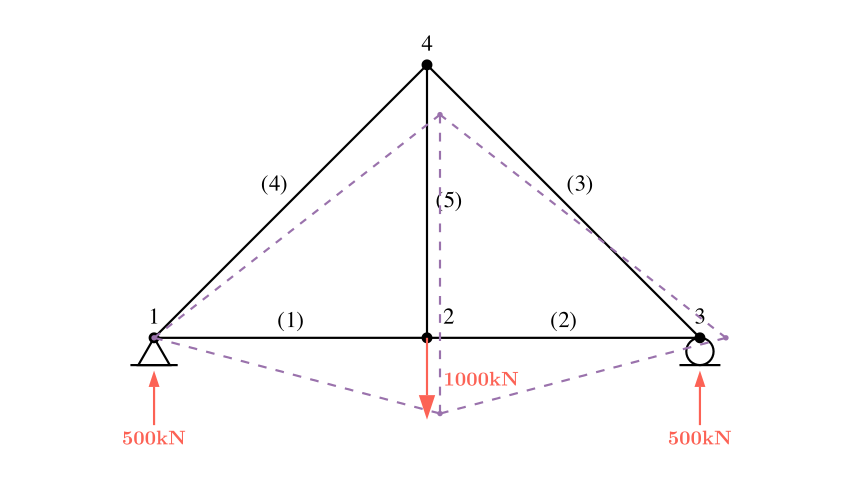

In [3]:

class ExampleTrussResults(MovingCameraScene):
    def __init__(self, **kargs):
        super().__init__(**kargs)
        self.camera.frame.scale(1.1)
        self.camera.frame.move_to(ORIGIN)

    def construct(self):
        nodes = np.array([(0, 0, 0), (5, 0, 0), (10, 0, 0), (5, 5, 0)], dtype=float)
        supports = {0: (True, True), 2: (False, True)}
        connectivity_matrix = np.array([(0, 1), (1, 2), (2, 3), (3, 0), (1, 3)])
        loads = {1: [0., -1000e3]}

        A = [.0025] * len(connectivity_matrix)
        E = [210.e9] * len(connectivity_matrix)

        u, N = analyze_truss_with_opensees(nodes, connectivity_matrix, supports, loads, A, E)
        print(u)
        font_size = 30
        g = Truss(nodes=nodes,
                  connectivity_matrix=connectivity_matrix,
                  supports=supports,
                  loads=loads,
                  displacements=u,
                  support_style={'height': .5},
                  node_label_offsets=[.4 * UP, .4 * (UP + RIGHT), .4 * UP, .4 * UP],
                  member_label_offsets=[.3 * UP, .3 * UP, .3 * UR, .3 * UL, .4 * RIGHT],
                  load_labels=['1000kN'],
                  load_label_offsets=[1 * RIGHT],
                  load_label_style={'prefix': '\\textbf{', 'suffix': '}'},
                  tip_style={'tip_length': .45, 'tip_width': .3},
                  display_node_labels=True,
                  display_load_labels=True,
                  display_member_labels=True,
                  deformed_style={'dash_length': .15})

        g.move_to(ORIGIN)
        g.overlap_deformation(scale=50)
        g.update()

        r2 = VGroup(
            Line([0, 0, 0], [0, 1, 0], color=RED, stroke_width=4)
            .add_tip(**{'tip_length': .3, 'tip_width': .2})
        ).next_to(g.supports[0], DOWN, .1)

        r1 = VGroup(
            Line([0, 0, 0], [1, 0, 0], color=RED, stroke_width=4)
            .add_tip(**{'tip_length': .3, 'tip_width': .2})
        ).move_to(r2)

        r3 = VGroup(
            Line([0, 0, 0], [0, 1, 0], color=RED, stroke_width=4)
            .add_tip(**{'tip_length': .3, 'tip_width': .2})
        ).next_to(g.supports[1], DOWN, .1)

        r1.add(Tex(r"$r_1$", color=RED, font_size=font_size).next_to(r1, LEFT, .1))
        r2.add(Tex(r"$\textbf{500kN}$", color=RED, font_size=35).next_to(r2, DOWN, .1))
        r3.add(Tex(r"$\textbf{500kN}$", color=RED, font_size=35).next_to(r3, DOWN, .1))

        self.add(g, r2, r3)

        all_group = get_all_vmobjects(self)
        all_group.center()
        path = "img/03-example_truss_results.svg"
        all_group.to_svg(path, crop=True)

%manim --format png -ql -v WARNING ExampleTrussResults

Manim Community v0.19.0

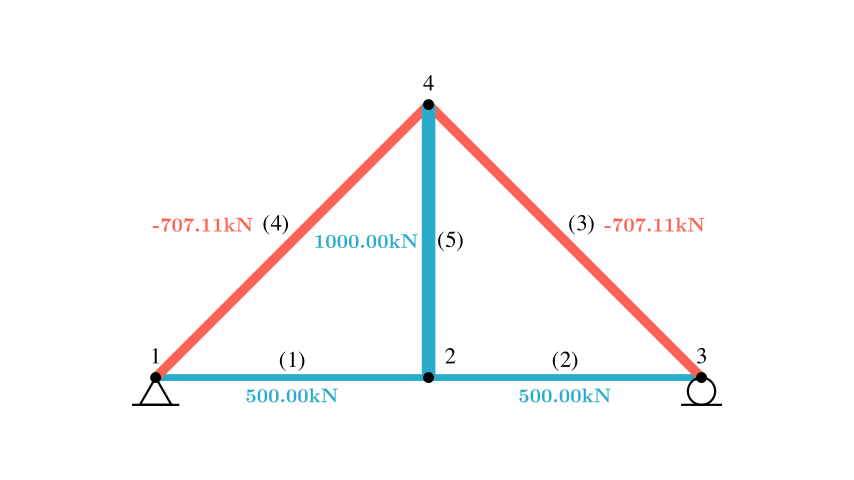

In [48]:

class ExampleTrussForces(MovingCameraScene):
    def __init__(self, **kargs):
        super().__init__(**kargs)
        self.camera.frame.scale(1.1)
        self.camera.frame.move_to(ORIGIN)

    def construct(self):
        nodes = np.array([(0, 0, 0), (5, 0, 0), (10, 0, 0), (5, 5, 0)], dtype=float)
        supports = {0: (True, True), 2: (False, True)}
        connectivity_matrix = np.array([(0, 1), (1, 2), (2, 3), (3, 0), (1, 3)])
        loads = {1: [0., -1000e3]}

        A = [.0025] * len(connectivity_matrix)
        E = [210.e9] * len(connectivity_matrix)

        u, N = analyze_truss_with_opensees(nodes, connectivity_matrix, supports, loads, A, E)

        font_size = 30
        g = Truss(nodes=nodes,
                  connectivity_matrix=connectivity_matrix,
                  supports=supports,
                  loads=loads,
                  displacements=u,
                  support_style={'height': .5},
                  node_label_offsets=[.4 * UP, .4 * (UP + RIGHT), .4 * UP, .4 * UP],
                  member_label_offsets=[.3 * UP, .3 * UP, .3 * UR, .3 * UL, .4 * RIGHT],
                  load_labels=['1000kN'],
                  load_label_offsets=[1 * RIGHT],
                  load_label_style={'prefix': '\\textbf{', 'suffix': '}'},
                  tip_style={'tip_length': .45, 'tip_width': .3},
                  display_node_labels=True,
                  display_loads=False,
                  display_load_labels=False,
                  display_member_labels=True,
                  deformed_style={'dash_length': .15})

        g.move_to(ORIGIN)
        g.toggle_normal_forces(N)
        g.update()

        texts = VGroup()
        (texts.add(Tex(rf"$\textbf{{{1e-3 * N[0]:.2f}kN}}$", color=BLUE_D, font_size=35)
                   .next_to(g.members[0], DOWN, .2)))
        (texts.add(Tex(rf"$\textbf{{{1e-3 * N[1]:.2f}kN}}$", color=BLUE_D, font_size=35)
                   .next_to(g.members[1], DOWN, .2)))
        (texts.add(Tex(rf"$\textbf{{{1e-3 * N[2]:.2f}kN}}$", color=RED, font_size=35)
                   .next_to(g.members_labels[2], RIGHT, .2)))
        (texts.add(Tex(rf"$\textbf{{{1e-3 * N[3]:.2f}kN}}$", color=RED, font_size=35)
                   .next_to(g.members_labels[3], LEFT, .2)))
        (texts.add(Tex(rf"$\textbf{{{1e-3 * N[4]:.2f}kN}}$", color=BLUE_D, font_size=35)
                   .next_to(g.members[4], LEFT, .2)))

        self.add(g, texts)

        all_group = get_all_vmobjects(self)
        all_group.center()
        path = "img/03-example_truss_forces.svg"
        all_group.to_svg(path, crop=True)

%manim --format png -ql -v WARNING ExampleTrussForces

Manim Community v0.19.0

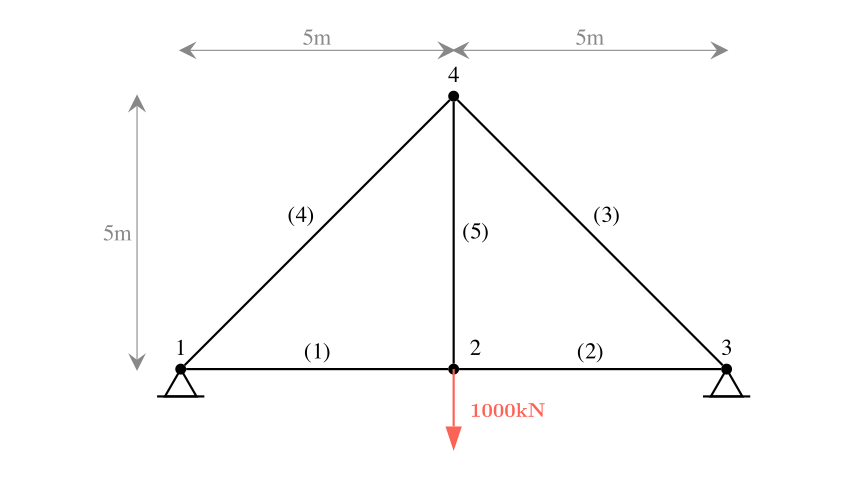

In [3]:

class ExampleHyperstaticTruss(MovingCameraScene):
    def __init__(self, **kargs):
        super().__init__(**kargs)
        self.camera.frame.scale(1.1)
        self.camera.frame.move_to(ORIGIN)

    def construct(self):
        nodes = np.array([(0, 0, 0), (5, 0, 0), (10, 0, 0), (5, 5, 0)], dtype=float)
        supports = {0: (True, True), 2: (True, True)}
        connectivity_matrix = np.array([(0, 1), (1, 2), (2, 3), (3, 0), (1, 3)])
        loads = {1: [0., -1000e3]}

        A = [.0025] * len(connectivity_matrix)
        E = [210.e9] * len(connectivity_matrix)

        u, N = analyze_truss_with_opensees(nodes, connectivity_matrix, supports, loads, A, E)

        font_size = 30
        g = Truss(nodes=nodes,
                  connectivity_matrix=connectivity_matrix,
                  supports=supports,
                  loads=loads,
                  displacements=u,
                  support_style={'height': .5},
                  node_label_offsets=[.4 * UP, .4 * (UP + RIGHT), .4 * UP, .4 * UP],
                  member_label_offsets=[.3 * UP, .3 * UP, .3 * UR, .3 * UL, .4 * RIGHT],
                  load_labels=['1000kN'],
                  load_label_offsets=[1 * RIGHT],
                  load_label_style={'prefix': '\\textbf{', 'suffix': '}'},
                  tip_style={'tip_length': .45, 'tip_width': .3},
                  display_node_labels=True,
                  display_load_labels=True,
                  display_member_labels=True)

        g.move_to(ORIGIN)
        tips_kwargs = {'tip_shape': StealthTip, 'tip_length': .25}
        arrows_L = VGroup(
            Line(g.nodes[0].get_center(), g.nodes[1].get_center(), color=GRAY, stroke_width=2),
            Line(g.nodes[1].get_center(), g.nodes[2].get_center(), color=GRAY, stroke_width=2)
        ).next_to(g, UP, buff=.3)

        texts = []
        for arrow in arrows_L:
            text = Text("5m", color=GRAY, font_size=font_size).next_to(arrow, UP, .1)
            texts.append(text)
            arrow.add_tip(**tips_kwargs, at_start=True)
            arrow.add_tip(**tips_kwargs)
        arrows_L.add(*texts)

        arrow_H = (VGroup(Line(g.nodes[1].get_center(), g.nodes[3].get_center(), color=GRAY, stroke_width=2))
                   .shift(5.8 * LEFT))
        arrow_H.add(Text("5m", color=GRAY, font_size=font_size).next_to(arrow_H, LEFT, .1))
        arrow_H[0].add_tip(**tips_kwargs, at_start=True).add_tip(**tips_kwargs)

        self.add(g, arrows_L, arrow_H)

        all_group = get_all_vmobjects(self)
        all_group.center()
        path = "img/03-example_truss_hyperstatic.svg"
        all_group.to_svg(path, crop=True)

%manim --format png -ql -v WARNING ExampleHyperstaticTruss

Manim Community v0.19.0

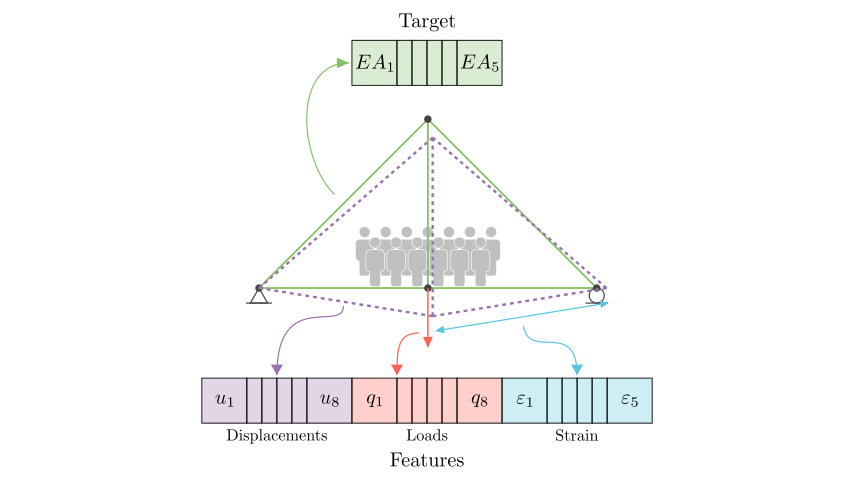

In [6]:
class DataSource(MovingCameraScene):
    def __init__(self, **kargs):
        super().__init__(**kargs)
        self.camera.frame.scale(2)
        self.camera.frame.move_to(ORIGIN)

    def construct(self):
        nodes = np.array([(0, 0, 0), (7.5, 0, 0), (15, 0, 0), (7.5, 7.5, 0)], dtype=float)
        supports = {0: (True, True), 2: (False, True)}
        connectivity_matrix = np.array([(0, 1), (1, 2), (2, 3), (3, 0), (1, 3)])
        loads = {1: [0., -1000e3]}

        A = [.0025] * len(connectivity_matrix)
        E = [210.e9] * len(connectivity_matrix)

        u, N = analyze_truss_with_opensees(nodes, connectivity_matrix, supports, loads, A, E)
        nodes *= 1.5
        font_size = 30
        g = Truss(nodes=nodes,
                  connectivity_matrix=connectivity_matrix,
                  supports=supports,
                  loads=loads,
                  displacements=u,
                  member_style={'stroke_color': GREEN, 'stroke_width': 6},
                  node_style={'radius': .25, 'color': DARK_GRAY},
                  support_style={'height': 1, 'color': DARK_GRAY},
                  load_style={'scale': 4, 'stroke_width': 5},
                  tip_style={'tip_length': .75, 'tip_width': .65},
                  deformed_style={'dash_length': .25, 'stroke_width': 8},
                  display_node_labels=False,
                  display_load_labels=False,
                  display_member_labels=False)

        g.move_to(ORIGIN)
        g.overlap_deformation(45)
        g.update()

        for load in g.loads:
            self.bring_to_front(load)

        crowd = SVGMobject("ref_img/crowd2.svg")
        crowd.scale(4 / crowd.height)
        crowd.next_to(g.loads, UP, buff=.1)

        self.add(crowd, g)

        all_group = get_all_vmobjects(self)
        all_group.center().scale(.5)

        h = 1.5
        w = h
        h_fold = h / 3
        font_size = 65

        u_vars = self.create_variables(h, w, h_fold, angle=PI / 2,
                                       text_1=Tex(r"$u_1$", color=BLACK, font_size=font_size),
                                       text_2=Tex(r"$u_8$", color=BLACK, font_size=font_size),
                                       color=BLACK, fill_color=PURPLE, fill_opacity=.3)
        q_vars = self.create_variables(h, w, h_fold, angle=PI / 2,
                                       text_1=Tex(r"$q_1$", color=BLACK, font_size=font_size),
                                       text_2=Tex(r"$q_8$", color=BLACK, font_size=font_size),
                                       color=BLACK, fill_color=RED, fill_opacity=.3).next_to(u_vars, RIGHT, 0.)
        strain_vars = self.create_variables(h, w, h_fold, angle=PI / 2,
                                            text_1=Tex(r"$\varepsilon_1$", color=BLACK, font_size=font_size),
                                            text_2=Tex(r"$\varepsilon_5$", color=BLACK, font_size=font_size),
                                            color=BLACK, fill_color=BLUE, fill_opacity=.3).next_to(q_vars, RIGHT, 0.)
        ea_vars = self.create_variables(h, w, h_fold, angle=PI / 2,
                                        text_1=Tex(r"$EA_1$", color=BLACK, font_size=font_size),
                                        text_2=Tex(r"$EA_5$", color=BLACK, font_size=font_size),
                                        color=BLACK, fill_color=GREEN, fill_opacity=.3)
        features = VGroup(u_vars, q_vars, strain_vars)
        target = VGroup(ea_vars)

        target.add(Tex(r"$\text{Target}$", font_size=font_size, color=BLACK).next_to(target, UP, .3))
        features.add(Tex(r"$\text{Displacements}$", font_size=font_size * .8, color=BLACK).next_to(u_vars, DOWN, .2),
                     Tex(r"$\text{Loads}$", font_size=font_size * .8, color=BLACK).next_to(q_vars, DOWN, .2),
                     Tex(r"$\text{Strain}$", font_size=font_size * .8, color=BLACK).next_to(strain_vars, DOWN, .2))
        features.add(Tex(r"$\text{Features}$", font_size=font_size, color=BLACK).next_to(features, DOWN, .3))

        features.next_to(g, DOWN, 1)
        target.next_to(g, UP, 1)

        tip_kwargs = {'length': .4, 'width': .35}

        arrow_target = VGroup(CubicBezier(g.members[3].get_center() + .3 * UL, g.members[3].get_center() + 1.5 * UL,
                                          target[0].get_left() + 2 * LEFT, target[0].get_left() + .1 * LEFT,
                                          color=GREEN, stroke_width=4),
                              ArrowTriangleFilledTip(**tip_kwargs, color=GREEN, start_angle=0.)
                              .next_to(target[0].get_left(), LEFT, .1))

        #v = Line(g.displaced_members[0].get_start(), g.displaced_members[0].get_end()).rotate(-PI / 2).get_vector()
        #v /= np.linalg.norm(v)
        v = DOWN

        arrow_u = VGroup(CubicBezier(g.members[0].get_center() + .6 * v, g.members[0].get_center() + 1.5 * v,
                                     u_vars.get_top() + 3 * UP, u_vars.get_top() + .1 * UP,
                                     color=PURPLE, stroke_width=4),
                         ArrowTriangleFilledTip(**tip_kwargs, color=PURPLE, start_angle=-PI / 2)
                         .next_to(u_vars.get_top(), UP, .1))

        arrow_q = VGroup(CubicBezier(g.loads[0].get_center() + .5* DOWN + .3 * LEFT, g.loads[0].get_center() + .5 * DOWN + 1 * LEFT,
                                     q_vars.get_top() + 1 * UP + 1. * LEFT, q_vars.get_top() + .1 * UP + 1. * LEFT,
                                     color=RED, stroke_width=4),
                         ArrowTriangleFilledTip(**tip_kwargs, color=RED, start_angle=-PI / 2)
                         .next_to(q_vars.get_top() + 1. * LEFT, UP, .1))

        idx = 1
        strain_mark = Line(g.displaced_members[idx].get_start(), g.displaced_members[idx].get_end(), color=BLUE)
        v = strain_mark.copy().rotate(-PI / 2).get_vector()
        v /= np.linalg.norm(v)
        strain_mark.shift(v * .5)
        (strain_mark
         .add_tip(**{f"tip_{k}": .75 * v for k, v in tip_kwargs.items()})
         .add_tip(**{f"tip_{k}": .75 * v for k, v in tip_kwargs.items()}, at_start=True))

        arrow_strain = VGroup(CubicBezier(strain_mark.get_center() + .3 * v, strain_mark.get_center() + 1.5 * v,
                                          strain_vars.get_top() + 2 * UP, strain_vars.get_top() + .1 * UP,
                                          color=BLUE, stroke_width=4),
                              ArrowTriangleFilledTip(**tip_kwargs, color=BLUE, start_angle=-PI / 2)
                              .next_to(strain_vars.get_top(), UP, .1))

        self.add(features, target, arrow_target, arrow_u, arrow_q, arrow_strain, strain_mark)

        all_group = get_all_vmobjects(self)
        all_group.center().scale(1)
        path = "img/03-data_source.svg"
        all_group.to_svg(path, crop=True)

    def create_variables(self, h, w, h_fold, text_1=None, text_2=None, stroke_width=3, angle=None,
                         n_fold=4, color=BLACK, fill_color=None, fill_opacity=.5):
        variables = VGroup()
        variables.add(
            Rectangle(height=h, width=w, stroke_color=color, fill_color=fill_color, fill_opacity=fill_opacity,
                      stroke_width=stroke_width),
            *[Rectangle(height=h_fold, width=w, stroke_color=color, fill_color=fill_color, fill_opacity=fill_opacity,
                        stroke_width=stroke_width)
              for _ in range(n_fold)],
            Rectangle(height=h, width=w, stroke_color=color, fill_color=fill_color, fill_opacity=fill_opacity,
                      stroke_width=stroke_width))
        for i, variable in enumerate(variables[1:]):
            variable.next_to(variables[i], DOWN, buff=0)

        if angle: variables.rotate(angle)

        if text_1:
            text_1.move_to(variables[0])
            variables.add(text_1)
        if text_2:
            text_2.move_to(variables[-2])
            variables.add(text_2)

        return variables

%manim --format png -ql -v WARNING DataSource

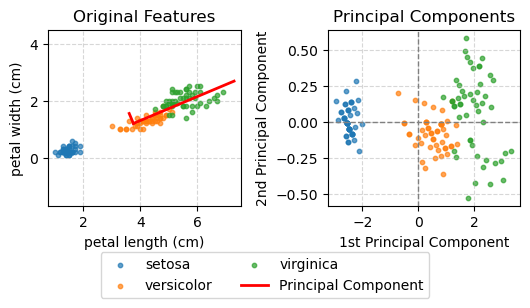

In [102]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.datasets import load_iris


class PCADemoIris:
    def __init__(self, classes=(0, 1, 2), features=('petal length (cm)', 'petal width (cm)')):
        iris = load_iris()
        X_full = iris.data
        y_full = iris.target
        feature_names = iris.feature_names

        # Select specified classes
        mask = np.isin(y_full, classes)
        X_sel = X_full[mask]
        y_sel = y_full[mask]

        # Map to 0/1
        self.y = y_sel  # y_sel == classes[1]).astype(int)

        # Select features by name
        idx_f1 = feature_names.index(features[0])
        idx_f2 = feature_names.index(features[1])
        self.X = X_sel[:, [idx_f1, idx_f2]]
        self.feature_names = features
        self.target_names = iris.target_names[list(classes)]

        self.pca = PCA(n_components=2)
        self.X_pca = None

    def apply_pca(self):
        self.X_pca = self.pca.fit_transform(self.X)

    def plot(self):
        if self.X_pca is None:
            raise RuntimeError("Call apply_pca() before plotting.")

        fig, axes = plt.subplots(1, 2, figsize=(5.4, 2.7))

        # Original data + principal axes
        ax1 = axes[0]
        sc = []
        for i in np.unique(self.y):
            sci = ax1.scatter(self.X[self.y == i, 0], self.X[self.y == i, 1], label=self.target_names[i], alpha=0.7,
                              s=10)
            sc.append(sci)
        arrows = []
        for length, vector in zip(self.pca.explained_variance_, self.pca.components_):
            v = vector * np.sqrt(length) * 2
            origin = self.pca.mean_
            arr_line, = ax1.plot([origin[0], origin[0] + v[0]], [origin[1], origin[1] + v[1]], color='red', linewidth=2)
            arrows.append(arr_line)
        ax1.set_title("Original Features", fontsize=12)
        ax1.set_xlabel(self.feature_names[0], fontsize=10)
        ax1.set_ylabel(self.feature_names[1], fontsize=10)
        ax1.axis('equal')
        ax1.grid(True, linestyle='--', alpha=0.5)

        # PCA-transformed data
        ax2 = axes[1]
        for i in np.unique(self.y):
            ax2.scatter(self.X_pca[self.y == i, 0], self.X_pca[self.y == i, 1], label=self.target_names[i], alpha=0.7,
                        s=10)

        ax2.axhline(0, color='gray', linestyle='--', linewidth=1)
        ax2.axvline(0, color='gray', linestyle='--', linewidth=1)
        ax2.set_title("Principal Components", fontsize=12)
        ax2.set_xlabel("1st Principal Component", fontsize=10)
        ax2.set_ylabel("2nd Principal Component", fontsize=10)
        #ax2.axis('equal')
        ax2.grid(True, linestyle='--', alpha=0.5)

        # Single legend below
        handles = [*sc, arrows[0]]
        labels = [*self.target_names, 'Principal Component']
        fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.15), ncol=2, fontsize=10)
        plt.subplots_adjust(bottom=0.25)

        plt.tight_layout()
        plt.savefig("img/03-PCA.pdf", bbox_inches='tight', transparent=True)
        plt.show()
        plt.close()


# Example usage
demo = PCADemoIris()
demo.apply_pca()
demo.plot()

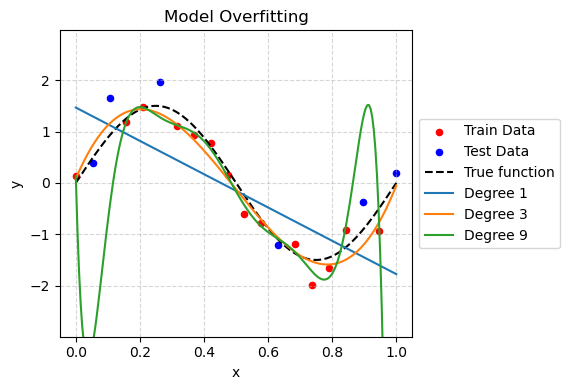

In [167]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


class OverfitDemo:
    def __init__(self, degrees=[1, 3, 9], n_samples=30, noise=0.2, random_seed=0):
        np.random.seed(random_seed)
        # Generate synthetic 1D data
        self.f = lambda X: 1.5 * np.sin(2 * np.pi * X)
        self.X = np.linspace(0, 1, n_samples)
        self.y = self.f(self.X) + np.random.normal(scale=noise, size=n_samples)
        self.X = self.X.reshape(-1, 1)

        # Split into train/test
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            self.X, self.y, test_size=0.3, random_state=random_seed
        )

        self.degrees = degrees
        self.models = []
        self.train_errors = []
        self.test_errors = []
        self._fit_models()

    def _fit_models(self):
        for deg in self.degrees:
            model = Pipeline([
                ('poly', PolynomialFeatures(degree=deg)),
                ('linreg', LinearRegression())
            ])
            model.fit(self.X_train, self.y_train)
            self.models.append(model)
            # Calculate errors
            y_train_pred = model.predict(self.X_train)
            y_test_pred = model.predict(self.X_test)
            self.train_errors.append(mean_squared_error(self.y_train, y_train_pred))
            self.test_errors.append(mean_squared_error(self.y_test, y_test_pred))

    def plot(self):
        # Create a dense grid for smooth curves
        X_plot = np.linspace(0, 1, 200).reshape(-1, 1)

        fig, ax = plt.subplots(figsize=(5.8, 4))

        # Left: data + fits
        ax.scatter(self.X_train, self.y_train, label='Train Data', color='red', s=20)
        ax.scatter(self.X_test, self.y_test, label='Test Data', color='blue', s=20)
        ax.plot(np.linspace(0, 1, 1000), self.f(np.linspace(0, 1, 1000)), color='black', linestyle='--',
                label='True function')
        for deg, model in zip(self.degrees, self.models):
            y_plot = model.predict(X_plot)
            ax.plot(X_plot, y_plot, label=f'Degree {deg}')

        ax.set_title('Model Overfitting', fontsize=12)
        ax.set_xlabel('x', fontsize=10)
        ax.set_ylabel('y', fontsize=10)
        ax.legend(fontsize=10, loc='center left', bbox_to_anchor=(1, .5))
        ax.grid(True, linestyle='--', alpha=0.5)

        ax.set_ylim(
            (
                np.min(np.hstack((self.y_test, self.y_train))) - 1,
                np.max(np.hstack((self.y_test, self.y_train))) + 1
            )
        )

        plt.tight_layout()
        fig.savefig("img/03-overfitting.pdf", bbox_inches='tight', transparent=True)
        plt.show()


# Example usage
demo = OverfitDemo(n_samples=20, noise=.3, random_seed=5)
demo.plot()


Manim Community v0.19.0

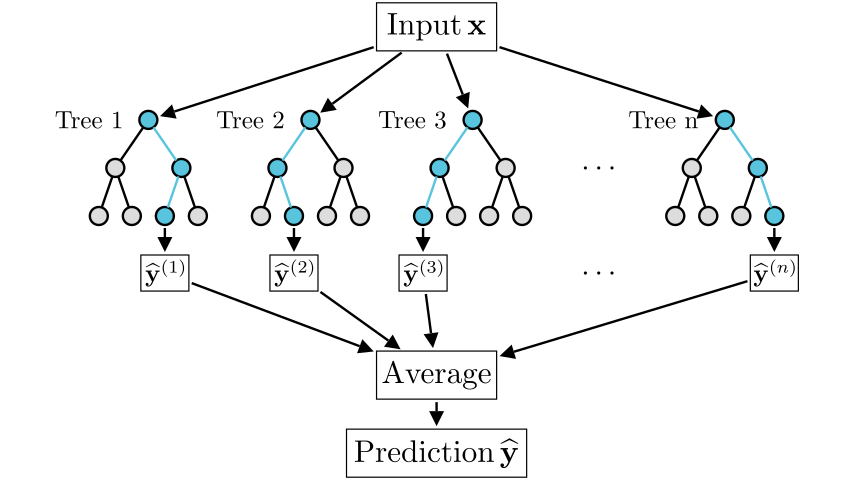

In [68]:
class RandomForestRegressor(Scene):
    def construct(self):
        trees = VGroup(*[
            BinaryTree(2, node_radius=.15, node_color=GRAY_A, h_spacing=.25)
            for _ in range(4)
        ])
        tip_kwargs = {
            'tip_length': .25,
            'tip_width': .25
        }
        arrow_buff = .05
        trees.arrange(buff=.75)
        trees[-1].shift(RIGHT * 1.5)
        activation_color = 'blue'

        trees_pred = VGroup()
        trees_pred_arrows = VGroup()
        for k, (tree, path) in enumerate(zip(trees, [[0, 1, 2], [0, 0, 1], [0, 0, 0], [0, 1, 3]])):
            for i, j in enumerate(path):
                if i > 0: tree.connections[i - 1][j].set(stroke_color=activation_color)
                node = tree.layers[i][j]
                node.set(fill_color=activation_color)
            pred = Operator(.6, .8, rf'$\widehat{{\mathbf{{y}}}}^{{({k + 1 if k < (len(trees) - 1) else 'n'})}}$',
                            font_size=40).next_to(
                node, DOWN, .5)
            trees_pred.add(pred)
            connection = Line(node.get_bottom(), pred.get_top(), color=BLACK, buff=arrow_buff)
            connection.add_tip(**tip_kwargs)
            trees_pred_arrows.add(connection)

        tree_inter = Tex(r"$\cdots$", color=BLACK).move_to(trees[-2:])
        pred_inter = Tex(r"$\cdots$", color=BLACK).move_to([tree_inter.get_center()[0], trees_pred.get_center()[1], 0])

        input = Operator(.8, 2, r'$\text{Input}\,\mathbf{x}$', font_size=50).next_to(trees, UP, 1)
        input_connection = VGroup()
        tree_name = VGroup()
        for i, tree in enumerate(trees):
            root: Dot = tree.layers[0][0]
            name = (Tex(rf"$\text{{Tree {i + 1 if i < (len(trees) - 1) else 'n'}}}$", font_size=40, color=BLACK)
                    .next_to(root, LEFT, .3))
            tree_name.add(name)
            start = input.get_center()
            end = root.get_center()
            start = self._intersect_line_with_shape(start, end, input[0])
            end = self._intersect_line_with_shape(start, end, root)

            connection = Line(start, end, color=BLACK, buff=arrow_buff).add_tip(**tip_kwargs)
            input_connection.add(connection)

        average_operator = (Operator(.8, 2, rf'$\text{{Average}}$', font_size=50)
                            .next_to(trees_pred, DOWN, 1))
        average_operator.move_to([input.get_center()[0], average_operator.get_center()[1], 0])
        pred_arrows = VGroup()
        for pred in trees_pred:
            start = pred.get_center()
            end = average_operator.get_center()
            start = self._intersect_line_with_shape(start, end, pred[0])
            end = self._intersect_line_with_shape(start, end, average_operator[0])

            connection = Line(start, end, color=BLACK, buff=arrow_buff).add_tip(**tip_kwargs)
            pred_arrows.add(connection)

        final_pred = (Operator(.8, 3, rf'$\text{{Prediction}}\,\widehat{{\mathbf{{y}}}}$', font_size=50)
                      .next_to(average_operator, DOWN, .5))
        avg_arrow = (Line(average_operator.get_bottom(), final_pred.get_top(), color=BLACK, buff=arrow_buff)
                     .add_tip(**tip_kwargs))
        self.add(trees, input, trees_pred, tree_inter, pred_inter, input_connection,
                 trees_pred_arrows, average_operator, pred_arrows, final_pred, avg_arrow,
                 tree_name)

        all_group = get_all_vmobjects(self)
        all_group.center().scale(1)
        path = "img/03-random_forest.svg"
        all_group.to_svg(path, crop=True)

    def _intersect_line_with_shape(self, pointA, pointB, shape):
        """
        Find intersection of the segment A->B with a shape.
        Returns the closest intersection point to pointA.
        """
        ray = Line(start=pointA, end=pointB, buff=0)

        intersections = []
        for submob in shape.family_members_with_points():
            if isinstance(submob, VMobject):
                for i in range(len(submob.points) - 1):
                    p1, p2 = submob.points[i], submob.points[i + 1]
                    ip = self._segment_intersection(pointA, pointB, p1, p2)
                    if ip is not None:
                        intersections.append(ip)

        if intersections:
            # Return closest to pointA
            intersections.sort(key=lambda pt: np.linalg.norm(pt - pointA))
            return intersections[0]
        else:
            return None

    def _segment_intersection(self, a1, a2, b1, b2):
        """
        Compute the intersection of segment a1->a2 with b1->b2.
        Returns point or None if no intersection.
        """

        def perp(a):
            return np.array([-a[1], a[0], 0])

        da = a2 - a1
        db = b2 - b1
        dp = a1 - b1
        dap = perp(da)
        denom = np.dot(dap, db)
        if denom == 0:
            return None  # Parallel

        num = np.dot(dap, dp)
        intersection = (num / denom) * db + b1

        # Check it's within both segments
        if not all([
            self._is_between(intersection, a1, a2),
            self._is_between(intersection, b1, b2)
        ]):
            return None

        return intersection

    def _is_between(self, p, a, b):
        """Check if point p is between a and b (inclusive)"""
        minx, maxx = sorted([a[0], b[0]])
        miny, maxy = sorted([a[1], b[1]])
        return minx - 1e-6 <= p[0] <= maxx + 1e-6 and miny - 1e-6 <= p[1] <= maxy + 1e-6

%manim --format png -ql -v WARNING RandomForestRegressor

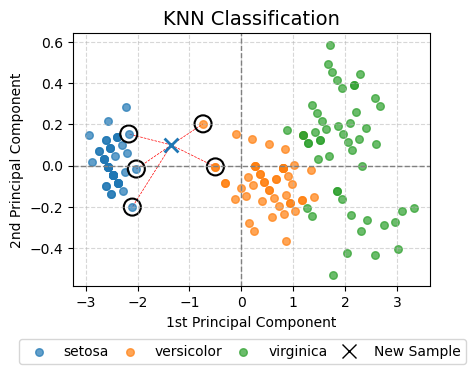

In [127]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.datasets import load_iris
from sklearn.neighbors import KNeighborsClassifier


class KNNDemoIris:
    def __init__(self, classes=(0, 1, 2), features=('petal length (cm)', 'petal width (cm)'), k=5):
        iris = load_iris()
        X_full = iris.data
        y_full = iris.target
        feature_names = iris.feature_names

        # Select specified classes
        mask = np.isin(y_full, classes)
        X_sel = X_full[mask]
        y_sel = y_full[mask]

        # Original features and labels
        self.X = X_sel[:, [feature_names.index(features[0]), feature_names.index(features[1])]]
        self.y = y_sel
        self.feature_names = features
        self.target_names = iris.target_names[list(classes)]

        # PCA for visualization
        self.pca = PCA(n_components=2)
        self.X_pca = self.pca.fit_transform(self.X)

        # Train KNN on PCA-transformed data
        self.k = k
        self.knn = KNeighborsClassifier(n_neighbors=k)
        self.knn.fit(self.X_pca, self.y)

        # Define three new sample points in original feature space
        self.new_samples = np.array([
            [5.0, 1.5],  # likely versicolor
            [1.5, 0.2],  # likely setosa
            [6.5, 2.2],  # likely virginica
        ])
        # Transform new samples to PCA space
        self.new_samples_pca = self.pca.transform(self.new_samples)
        self.new_samples_pca = np.array([
            [-1.35, .1],
            #[1.2, -.4],  # likely setosa
            #[1, .3],  # likely virginica
        ])
        # Predict their labels
        self.new_preds = self.knn.predict(self.new_samples_pca)
        # Find k nearest neighbors for each new sample
        self.neigh_dist, self.neigh_idx = self.knn.kneighbors(self.new_samples_pca)

    def plot(self):
        fig, ax = plt.subplots(figsize=(4.5, 3.5))

        # Plot existing data in PCA space
        for cls in np.unique(self.y):
            ax.scatter(self.X_pca[self.y == cls, 0],
                       self.X_pca[self.y == cls, 1],
                       label=self.target_names[cls], alpha=0.7, s=30)

        # Highlight k nearest neighbors for each new sample
        for i, (pt, preds, idxs) in enumerate(zip(self.new_samples_pca, self.new_preds, self.neigh_idx)):
            # Plot new sample
            ax.scatter(pt[0], pt[1], marker='x', s=100,
                       color=plt.cm.tab10(preds), linewidths=2)
            # Highlight neighbors with circles
            neigh_pts = self.X_pca[idxs]
            ax.scatter(neigh_pts[:, 0], neigh_pts[:, 1], facecolors='none', edgecolors='black', s=150, linewidths=1.5)
            for npt in neigh_pts:
                plt.plot([pt[0], npt[0]], [pt[1], npt[1]], linestyle='--', c='r', zorder=-2, linewidth=.5)
        # Decorate plot
        ax.axhline(0, color='gray', linestyle='--', linewidth=1)
        ax.axvline(0, color='gray', linestyle='--', linewidth=1)
        ax.set_title('KNN Classification', fontsize=14)
        ax.set_xlabel('1st Principal Component', fontsize=10)
        ax.set_ylabel('2nd Principal Component', fontsize=10)
        ax.grid(True, linestyle='--', alpha=0.5)

        # Single legend below
        handles, labels = ax.get_legend_handles_labels()
        cross_handle = plt.Line2D([], [], marker='x', color='black', linestyle='None', markersize=10,
                                  label='New Samples')
        handles.extend([cross_handle])
        labels.extend(['New Sample', f'{self.k} Neighbors'])
        fig.legend(handles, labels, loc='lower center', ncol=4, fontsize=10, bbox_to_anchor=(0.55, -0.075),
                   columnspacing=0.5)
        plt.subplots_adjust(bottom=0.2)

        plt.tight_layout()
        plt.savefig("img/03-KNN.pdf", bbox_inches='tight', transparent=True)
        plt.show()
        plt.close()


# Example usage
demo = KNNDemoIris()
demo.plot()


In [64]:
import numpy as np


def decompose_x(x):
    u = np.zeros((4, 3))
    u[1, [0, 1]] = x[[0, 1]]
    u[2, [0]] = x[2]
    u[3, [0, 1]] = x[[3, 4]]

    q = {1: [0., x[5]]}

    return u, q

Manim Community v0.19.0

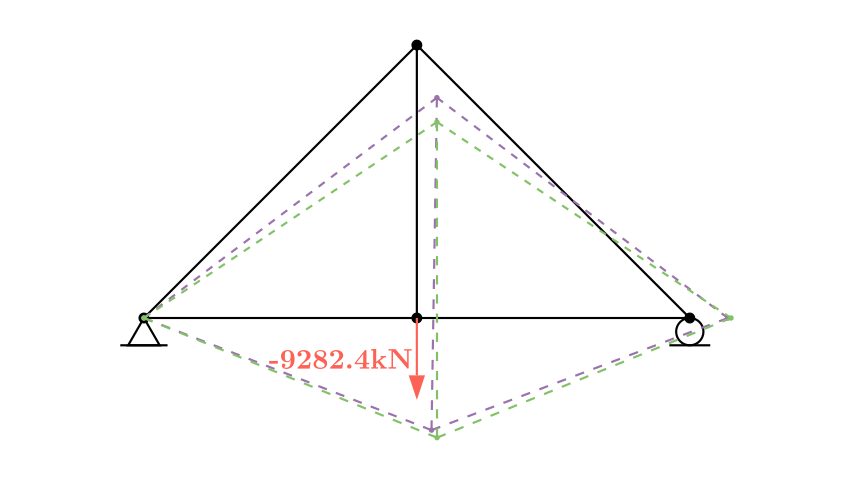

Manim Community v0.19.0

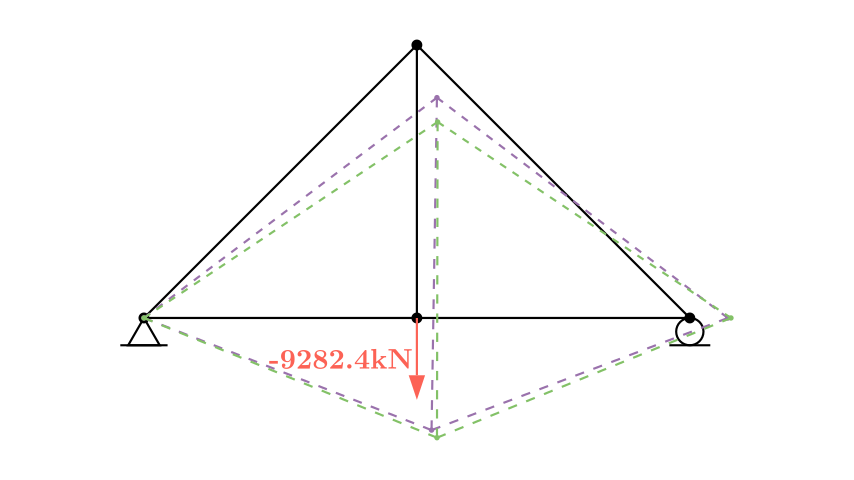

Manim Community v0.19.0

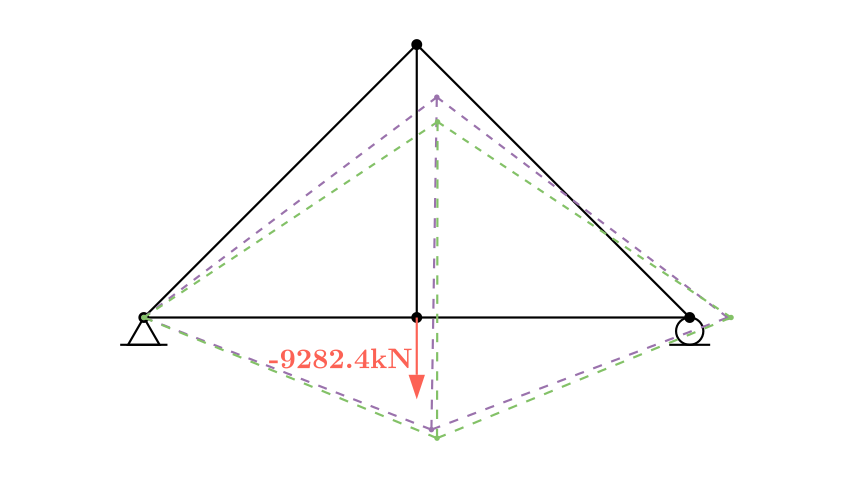

Manim Community v0.19.0

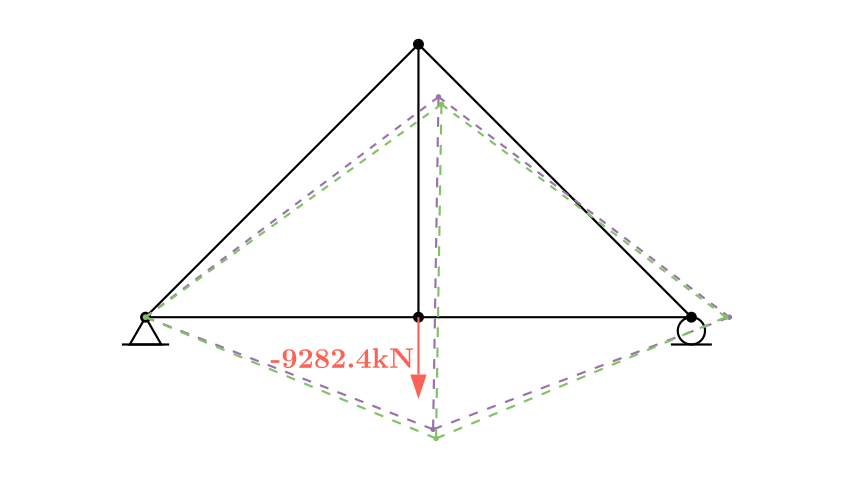

Manim Community v0.19.0

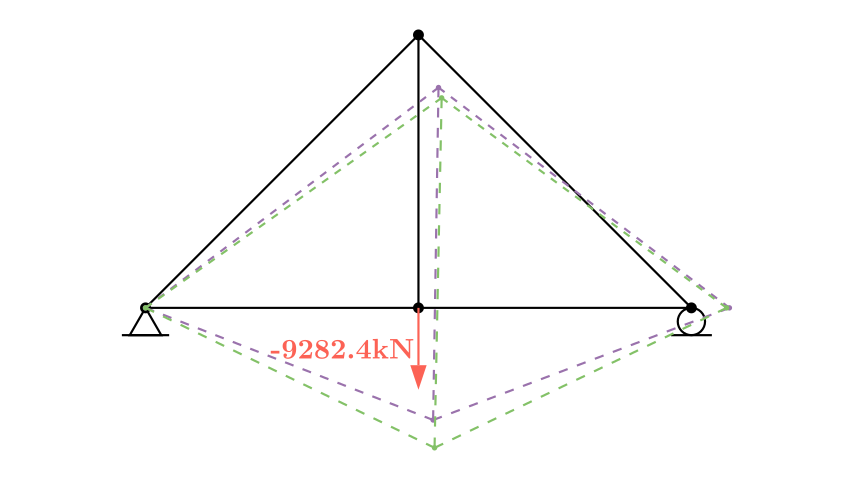

Manim Community v0.19.0

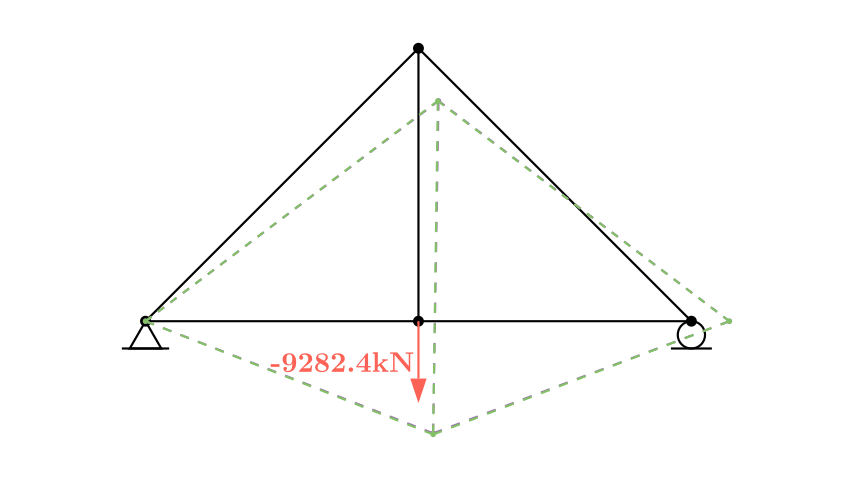

In [8]:
from figures.manim_custom import *
from manim import *

quality = "ql"
config['background_color'] = WHITE


class TrussPredComparison(MovingCameraScene):
    def __init__(self, file, **kargs):
        super().__init__(**kargs)
        self.camera.frame.scale(1.1)
        self.camera.frame.move_to(ORIGIN)
        self.file = file

    def construct(self):
        nodes = np.array([(0, 0, 0), (5, 0, 0), (10, 0, 0), (5, 5, 0)], dtype=float)
        supports = {0: (True, True), 2: (False, True)}
        connectivity_matrix = np.array([(0, 1), (1, 2), (2, 3), (3, 0), (1, 3)])
        x = np.loadtxt('x.dat')
        u_real, loads = decompose_x(x)

        font_size = 30
        g = Truss(nodes=nodes,
                  connectivity_matrix=connectivity_matrix,
                  supports=supports,
                  loads=loads,
                  displacements=u_real,
                  support_style={'height': .5},
                  node_label_offsets=[.4 * UP, .4 * (UP + RIGHT), .4 * UP, .4 * UP],
                  member_label_offsets=[.3 * UP, .3 * UP, .3 * UR, .3 * UL, .4 * RIGHT],
                  load_labels=[f'{loads[1][1] / 1000:.1f}kN'],
                  load_label_offsets=[1.4 * LEFT],
                  load_label_style={'prefix': '\\textbf{', 'suffix': '}', 'font_size': 50},
                  tip_style={'tip_length': .45, 'tip_width': .3},
                  display_node_labels=False,
                  display_load_labels=True,
                  display_member_labels=False,
                  deformed_style={'dash_length': .15})

        g.move_to(ORIGIN)
        g.overlap_deformation(scale=100)
        g.update()

        y_pred = np.loadtxt(self.file)
        u, N = analyze_truss_with_opensees(nodes, connectivity_matrix, supports, loads, y_pred, np.array([1.] * 5))

        members_obj, nodes_obj = g.overlap_deformation(scale=100, u=u)
        for l in members_obj: l.set(color=GREEN)
        for n in nodes_obj: n.set(color=GREEN)
        g.update()

        self.add(g)

        all_group = get_all_vmobjects(self)
        all_group.center()
        name = self.file.split('_')[1:]
        name = '_'.join(name).split('.')[0]
        path = f"img/03-pred_{name}.svg"
        all_group.to_svg(path, crop=True)


class TrussRegression(TrussPredComparison):
    def __init__(self, **kargs):
        super().__init__(file='pred_regression.dat', **kargs)


class TrussLasso(TrussPredComparison):
    def __init__(self, **kargs):
        super().__init__(file='pred_lasso.dat', **kargs)


class TrussRidge(TrussPredComparison):
    def __init__(self, **kargs):
        super().__init__(file='pred_ridge.dat', **kargs)


class TrussKNN(TrussPredComparison):
    def __init__(self, **kargs):
        super().__init__(file='pred_knn.dat', **kargs)


class TrussRandomForest(TrussPredComparison):
    def __init__(self, **kargs):
        super().__init__(file='pred_random_forest.dat', **kargs)


class TrussMLP4096(TrussPredComparison):
    def __init__(self, **kargs):
        super().__init__(file='pred_mlp_4096.dat', **kargs)

%manim --format png -ql -v WARNING TrussRegression
%manim --format png -ql -v WARNING TrussLasso
%manim --format png -ql -v WARNING TrussRidge
%manim --format png -ql -v WARNING TrussKNN
%manim --format png -ql -v WARNING TrussRandomForest
%manim --format png -ql -v WARNING TrussMLP4096

Manim Community v0.19.0

[[ 0.          0.        ]
 [ 0.00369408 -0.0219205 ]
 [ 0.00754661  0.        ]
 [ 0.00368097 -0.01409563]]
[6.28196659e+09 6.02360320e+09 6.41611725e+09 6.30234368e+09
 5.93137203e+09]


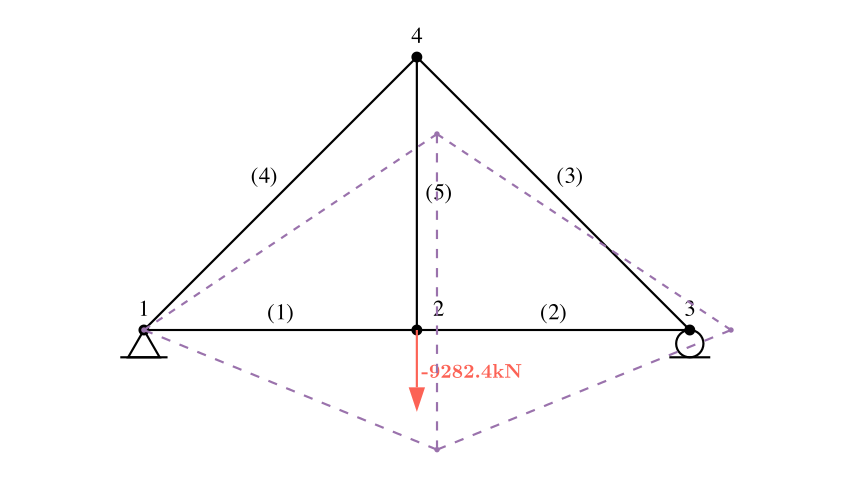

In [65]:
from figures.manim_custom import *
from manim import *

quality = "ql"
config['background_color'] = WHITE


class TrussRegression(MovingCameraScene):
    def __init__(self, **kargs):
        super().__init__(**kargs)
        self.camera.frame.scale(1.1)
        self.camera.frame.move_to(ORIGIN)

    def construct(self):
        nodes = np.array([(0, 0, 0), (5, 0, 0), (10, 0, 0), (5, 5, 0)], dtype=float)
        supports = {0: (True, True), 2: (False, True)}
        connectivity_matrix = np.array([(0, 1), (1, 2), (2, 3), (3, 0), (1, 3)])
        x = np.loadtxt('x.dat')
        _, loads = decompose_x(x)

        y_pred = np.loadtxt('pred_regression.dat')
        u, N = analyze_truss_with_opensees(nodes, connectivity_matrix, supports, loads, y_pred, np.array([1.] * 5))
        print(u)
        print(y_pred)
        font_size = 30
        g = Truss(nodes=nodes,
                  connectivity_matrix=connectivity_matrix,
                  supports=supports,
                  loads=loads,
                  displacements=u,
                  support_style={'height': .5},
                  node_label_offsets=[.4 * UP, .4 * (UP + RIGHT), .4 * UP, .4 * UP],
                  member_label_offsets=[.3 * UP, .3 * UP, .3 * UR, .3 * UL, .4 * RIGHT],
                  load_labels=[f'{loads[1][1] / 1000:.1f}kN'],
                  load_label_offsets=[1 * RIGHT],
                  load_label_style={'prefix': '\\textbf{', 'suffix': '}'},
                  tip_style={'tip_length': .45, 'tip_width': .3},
                  display_node_labels=True,
                  display_load_labels=True,
                  display_member_labels=True,
                  deformed_style={'dash_length': .15})

        g.move_to(ORIGIN)
        g.overlap_deformation(scale=100)
        g.update()

        self.add(g)

        all_group = get_all_vmobjects(self)
        all_group.center()
        path = "img/03-truss_regression.svg"
        all_group.to_svg(path, crop=True)

%manim --format png -ql -v WARNING TrussRegression

MLflow server started at http://127.0.0.1:5550
Metadata database: /Users/aflamant/Documents/courses/2024-2025/mémoire/05-results/dummy/001/mlruns.db
Artifacts directory: /Users/aflamant/Documents/courses/2024-2025/mémoire/05-results/dummy/001
Workers: 4
Process group: 52775
MLflow server started at http://127.0.0.1:5551
Metadata database: /Users/aflamant/Documents/courses/2024-2025/mémoire/05-results/dummy/005/mlruns.db
Artifacts directory: /Users/aflamant/Documents/courses/2024-2025/mémoire/05-results/dummy/005
Workers: 4
Process group: 52780


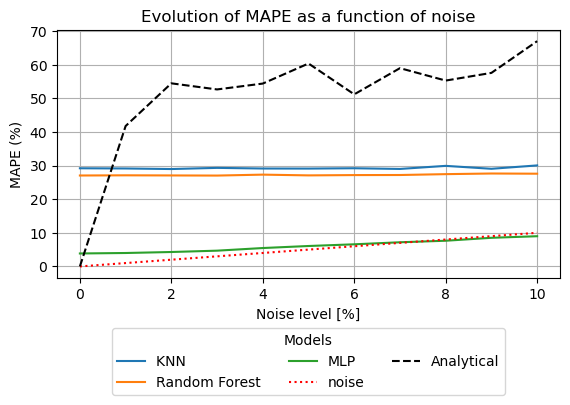

In [37]:
from tools import MLFlowSession
import mlflow
import os
import numpy as np
import matplotlib.pyplot as plt

import pickle

with open('classic_ml_mape_noise.pickle', 'rb') as f:
    classic_ml_mape = pickle.load(f)

for k in classic_ml_mape.keys():
    classic_ml_mape[k] = np.array(classic_ml_mape[k])

# Setup a memoire directory variable
memoire_dir = os.environ['memoire']
runs_dir = rf"{memoire_dir}/05-results/dummy"

server_mlp = MLFlowSession(PORT=5550, DIRECTORY=f"{runs_dir}/001", )
server_mlp.start(wait_time=1)
server_pinn = MLFlowSession(PORT=5551, DIRECTORY=f"{runs_dir}/005")
server_pinn.start(wait_time=1)


def get_mape(server):
    mlflow.set_tracking_uri(uri=server.url())
    experiment = mlflow.get_experiment_by_name("noise_sensitivity")

    runs_df = mlflow.search_runs(experiment_ids=[experiment.experiment_id])
    runs_df = runs_df[runs_df['params.train_size'] == '4096']

    id = list(runs_df['run_id'])[0]
    client = mlflow.tracking.MlflowClient()
    hist = client.get_metric_history(id, 'mape')
    return np.array([m.value for m in hist])


mape_mlp = get_mape(server_mlp)
mape_pinn = get_mape(server_pinn)
mape_analytical = np.loadtxt("../experiments/dummy_truss/analytical_mean_mape.dat")

fig, ax = plt.subplots(figsize=(5.8, 4.3))  # Wider figure for space

# MAPE Plot

plt.plot(100 * np.linspace(0, .1, 11), 100 * classic_ml_mape['KNN'], label='KNN   ')
plt.plot(100 * np.linspace(0, .1, 11), 100 * classic_ml_mape['Random Forest'], label='Random Forest')
plt.plot(100 * np.linspace(0, .1, 11), 100 * mape_mlp, label='MLP')
plt.plot(100 * np.linspace(0, .1, 11), 100 * np.linspace(0, .1, 11), label='noise', linestyle=':', c='r')
#plt.plot(100 * np.linspace(0, .1, 11), 100 * mape_pinn, label='PINN')

# Analytical benchmark
ax.plot(np.linspace(0, .1, 11) * 100, mape_analytical * 100, linestyle='--', c='black', label="Analytical")

# Labels and formatting
ax.set_ylabel("MAPE (%)", fontsize=10)
ax.set_title("Evolution of MAPE as a function of noise", fontsize=12)
ax.set_xlabel("Noise level [%]", fontsize=10)
ax.grid(True)

# Move legend outside the plot
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -.175), ncols=3, title="Models", fontsize=10)

lim = ax.get_ylim()
#ax.set_yticks(np.hstack((ax.get_yticks(), np.arange(0, 13, 2))))
ax.set_ylim(lim)

plt.tight_layout()  # Make room for legend

# Save
fig.savefig(r"img/03-mlp_mse_noise.pdf")

plt.show()

server_mlp.terminate()
server_pinn.terminate()

Manim Community v0.19.0

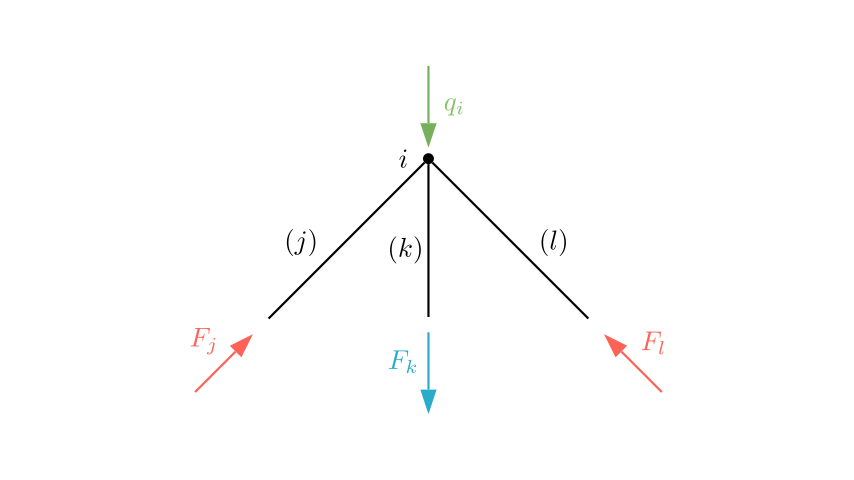

In [66]:
from figures.manim_custom import *
from manim import *

quality = "ql"
config['background_color'] = WHITE


class TrussRegression(MovingCameraScene):
    def __init__(self, **kargs):
        super().__init__(**kargs)
        self.camera.frame.scale(1.1)
        self.camera.frame.move_to(ORIGIN)

    def construct(self):
        nodes = np.array([(0, 0, 0), (3, 0, 0), (6, 0, 0), (3, 3, 0)], dtype=float)
        supports = {}
        connectivity_matrix = np.array([(0, 3), (1, 3), (2, 3)])

        font_size = 30
        g = Truss(nodes=nodes,
                  connectivity_matrix=connectivity_matrix,
                  supports=supports,
                  loads={3: [0., -1.]},
                  displacements=[[0., 0.] for _ in range(len(nodes))],
                  support_style={'height': .5},
                  node_label_offsets=[.4 * UP, .4 * (UP + RIGHT), .4 * UP, .4 * UP],
                  load_style={'color': GREEN_D},
                  member_label_offsets=[.3 * UP, .3 * UP, .3 * UR, .3 * UL, .4 * RIGHT],
                  tip_style={'tip_length': .45, 'tip_width': .3},
                  deformed_style={'dash_length': .15})
        g.loads[0].next_to(g.nodes[3], UP, buff=.1)
        g.nodes.remove(*g.nodes[:3])
        self.add(g)

        N = [member
             .copy()
             .scale(1.5 / np.linalg.norm(member.get_start() - member.get_end()))
             .set(color=color)
             .next_to(member, -member.get_vector(), buff=.1)
             .add_tip(**{'tip_length': .45, 'tip_width': .3}, at_start=i in {1})
             for i, (member, color) in enumerate(zip(g.members, ['RED', 'BLUE_D', 'RED']))]

        self.add(*N)

        label_forces = [
            Tex('$q_i$', color=GREEN).next_to(g.loads[0], RIGHT, buff=.15),
            *[
                Tex(f'$F_{i}$', color=color).next_to(vector.get_center(), vector.copy().rotate(angle).get_vector(), .15)
                for (i, angle, vector, color) in
                zip(['j', 'k', 'l'], [PI / 2, PI / 2, -PI / 2], N, ['RED', 'BLUE_D', 'RED'])
            ]
        ]

        label_members = [
            Tex(f'$({i})$', color=BLACK).next_to(member.point_from_proportion(0.35),
                                                 member.copy().rotate(angle).get_vector(), .05)
            for (i, angle, member) in zip(['j', 'k', 'l'], [PI / 2, PI / 2, -PI / 2], g.members)
        ]

        label_nodes = [
            Tex(f'$i$', color=BLACK).next_to(g.nodes[0], LEFT, buff=.3)
        ]

        self.add(*label_forces, *label_members, *label_nodes)

        all_group = get_all_vmobjects(self)
        all_group.center()
        path = "img/03-equilibrium-loss-node-zoom.svg"
        all_group.to_svg(path, crop=True)

%manim --format png -ql -v WARNING TrussRegression

In [3]:
nodes = np.array([(0, 0, 0), (5, 0, 0), (10, 0, 0), (5, 5, 0)], dtype=float)
supports = {0: (True, True), 2: (False, True)}
connectivity_matrix = np.array([(0, 1), (1, 2), (2, 3), (3, 0), (1, 3)])
loads = {1: [0., -1000e3]}

A = [.0025] * len(connectivity_matrix)
E = [210.e9] * len(connectivity_matrix)

u, N = analyze_truss_with_opensees(nodes, connectivity_matrix, supports, loads, A, E)

lengths = [np.linalg.norm(nodes[j] - nodes[i]) for i, j in connectivity_matrix]
ls = np.array([(nodes[j] - nodes[i]) / length for (i, j), length in zip(connectivity_matrix, lengths)])[:, :-1]

strains = [(u[j] - u[i]) @ l / length for (i, j), l, length in zip(connectivity_matrix, ls, lengths)]
for s in strains:
    print(f"{s:.7f}\\\\")

0.0009524\\
0.0009524\\
-0.0013469\\
-0.0013469\\
0.0019048\\


In [4]:
y = [ei * ai for ei, ai in zip(E, A)]

y_pred = np.array([500, 525, 510, 520, 525]) * 1e6
F = [EA * strain * 1e-3 for EA, strain in zip(y_pred, strains)]
print(F)

[np.float64(476.19047619047626), np.float64(500.0000000000002), np.float64(-686.9037302955037), np.float64(-700.3724308895331), np.float64(1000.0000000000001)]


In [5]:
factor = 2 ** .5 / 2

In [8]:
R1 = np.array([F[0] + factor * F[3], factor * F[3] + 500]).round(6)
print(*R1 * 1000, sep=r' & ')

R2 = np.array([-F[0] + F[1], F[4] - 1000]).round(6)
print(*R2 * 1000, sep=r' & ')

R3 = np.array([-F[1] - factor * F[2], factor * F[2] + 500]).round(6)
print(*R3 * 1000, sep=r' & ')

R4 = np.array([factor * F[2] - factor * F[3], -factor * F[2] - factor * F[3] - F[4]]).round(6)
print(*R4 * 1000, sep=r' & ')

mse_R = np.mean([(1e3 * Ri) ** 2. for Ri in [R1, R2, R3, R4]]) / 1e6
print(mse_R)

-19047.619000000002 & 4761.905
23809.524 & 0.0
-14285.714 & 14285.714
9523.81 & -19047.619000000002
226.75736967120193


In [16]:
u = u.reshape(-1)
q = np.zeros(8)
for k, v in loads.items():
    q[2 * k:2 * k + 2] = v
w_ext = 1 / 2 * u @ q
print(w_ext)

13877.207439871887


In [27]:
Us = [.5 * EA_i * li * s ** 2 for EA_i, li, s in zip(y_pred, lengths, strains)]
print(Us)
U = np.sum(Us)
print(U)
print((U - w_ext) ** 2)

[np.float64(1133.7868480725626), np.float64(1190.4761904761915), np.float64(3270.9701442643045), np.float64(3335.106813759683), np.float64(4761.904761904762)]
13692.244758477504
34211.19350860013


MLflow server started at http://127.0.0.1:6550
Metadata database: /Users/aflamant/Documents/courses/2024-2025/mémoire/05-results/dummy/001/mlruns.db
Artifacts directory: /Users/aflamant/Documents/courses/2024-2025/mémoire/05-results/dummy/001
Workers: 4
Process group: 4287
MLflow server started at http://127.0.0.1:6555
Metadata database: /Users/aflamant/Documents/courses/2024-2025/mémoire/05-results/dummy/005/mlruns.db
Artifacts directory: /Users/aflamant/Documents/courses/2024-2025/mémoire/05-results/dummy/005
Workers: 4
Process group: 4292


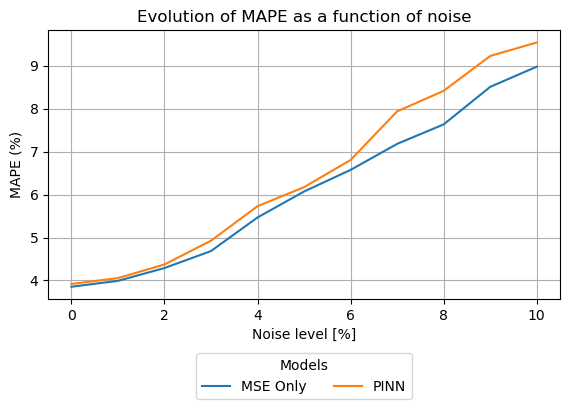

In [17]:
from tools import MLFlowSession
import mlflow
import os
import numpy as np
import matplotlib.pyplot as plt

import pickle

with open('classic_ml_mape_noise.pickle', 'rb') as f:
    classic_ml_mape = pickle.load(f)

for k in classic_ml_mape.keys():
    classic_ml_mape[k] = np.array(classic_ml_mape[k])

# Setup a memoire directory variable
memoire_dir = os.environ['memoire']
runs_dir = rf"{memoire_dir}/05-results/dummy"

server_mlp = MLFlowSession(PORT=6550, DIRECTORY=f"{runs_dir}/001", )
server_mlp.start(wait_time=1)
server_hybrid = MLFlowSession(PORT=6555, DIRECTORY=f"{runs_dir}/005")
server_hybrid.start(wait_time=1)


def get_mape(server, size='4096'):
    mlflow.set_tracking_uri(uri=server.url())
    experiment = mlflow.get_experiment_by_name("noise_sensitivity")

    runs_df = mlflow.search_runs(experiment_ids=[experiment.experiment_id])
    runs_df = runs_df[runs_df['params.train_size'] == size]

    id = list(runs_df['run_id'])[0]
    client = mlflow.tracking.MlflowClient()
    hist = client.get_metric_history(id, 'mape')
    return np.array([m.value for m in hist])


size = '4096'
mape_mlp = get_mape(server_mlp, size)
mape_pinn = get_mape(server_hybrid, size)
mape_analytical = np.loadtxt("../experiments/dummy_truss/analytical_mean_mape.dat")

fig, ax = plt.subplots(figsize=(5.8, 4.3))  # Wider figure for space

# MAPE Plot

plt.plot(100 * np.linspace(0, .1, 11), 100 * mape_mlp, label='MSE Only')
#plt.plot(100 * np.linspace(0, .1, 11), 100 * np.linspace(0, .1, 11), label='noise', linestyle=':', c='r')
plt.plot(100 * np.linspace(0, .1, 11), 100 * mape_pinn, label='PINN')

# Analytical benchmark
#ax.plot(np.linspace(0, .1, 11) * 100, mape_analytical * 100, linestyle='--', c='black', label="Analytical")

# Labels and formatting
ax.set_ylabel("MAPE (%)", fontsize=10)
ax.set_title("Evolution of MAPE as a function of noise", fontsize=12)
ax.set_xlabel("Noise level [%]", fontsize=10)
ax.grid(True)

# Move legend outside the plot
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -.175), ncols=3, title="Models", fontsize=10)

#lim = ax.get_ylim()
#ax.set_yticks(np.hstack((ax.get_yticks(), np.arange(0, 13, 2))))
#ax.set_ylim(lim)
#ax.set_yscale('log')
plt.tight_layout()  # Make room for legend

# Save
fig.savefig(r"img/03-mlp_pinn_noise-4096.pdf")
plt.show()

server_mlp.terminate()
server_hybrid.terminate()

MLflow server started at http://127.0.0.1:6550
Metadata database: /Users/aflamant/Documents/courses/2024-2025/mémoire/05-results/dummy/001/mlruns.db
Artifacts directory: /Users/aflamant/Documents/courses/2024-2025/mémoire/05-results/dummy/001
Workers: 4
Process group: 4796
MLflow server started at http://127.0.0.1:6555
Metadata database: /Users/aflamant/Documents/courses/2024-2025/mémoire/05-results/dummy/005/mlruns.db
Artifacts directory: /Users/aflamant/Documents/courses/2024-2025/mémoire/05-results/dummy/005
Workers: 4
Process group: 4800


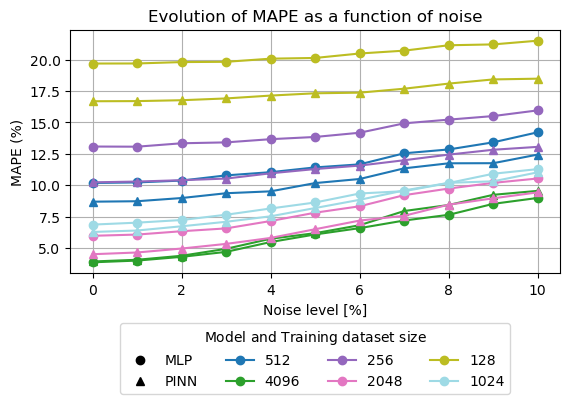

In [25]:
from tools import MLFlowSession
import mlflow
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.lines import Line2D

import pickle

with open('classic_ml_mape_noise.pickle', 'rb') as f:
    classic_ml_mape = pickle.load(f)

for k in classic_ml_mape.keys():
    classic_ml_mape[k] = np.array(classic_ml_mape[k])

# Setup a memoire directory variable
memoire_dir = os.environ['memoire']
runs_dir = rf"{memoire_dir}/05-results/dummy"

server_mlp = MLFlowSession(PORT=6550, DIRECTORY=f"{runs_dir}/001", )
server_mlp.start(wait_time=1)
server_hybrid = MLFlowSession(PORT=6555, DIRECTORY=f"{runs_dir}/005")
server_hybrid.start(wait_time=1)

mlflow.set_tracking_uri(uri=server_mlp.url())
experiment = mlflow.get_experiment_by_name("noise_sensitivity")
runs_df = mlflow.search_runs(experiment_ids=[experiment.experiment_id])
sizes = runs_df['params.train_size'].unique()


def get_mape(server, size='4096'):
    mlflow.set_tracking_uri(uri=server.url())
    experiment = mlflow.get_experiment_by_name("noise_sensitivity")

    runs_df = mlflow.search_runs(experiment_ids=[experiment.experiment_id])
    runs_df = runs_df[runs_df['params.train_size'] == size]

    id = list(runs_df['run_id'])[0]
    client = mlflow.tracking.MlflowClient()
    hist = client.get_metric_history(id, 'mape')
    return np.array([m.value for m in hist])


fig, ax = plt.subplots(figsize=(5.8, 4.3))  # Wider figure for space

cmap = mpl.colormaps['tab20']
c = cmap(np.linspace(0, 1, len(sizes)))

for i, size in enumerate(sizes):
    mape_mlp = get_mape(server_mlp, size)
    mape_pinn = get_mape(server_hybrid, size)

    plt.plot(100 * np.linspace(0, .1, 11), 100 * mape_mlp, marker='o', c=c[i], label=size)
    plt.plot(100 * np.linspace(0, .1, 11), 100 * mape_pinn, marker='^', c=c[i])

# Labels and formatting
ax.set_ylabel("MAPE (%)", fontsize=10)
ax.set_title("Evolution of MAPE as a function of noise", fontsize=12)
ax.set_xlabel("Noise level [%]", fontsize=10)
ax.grid(True)

# Custom handles for model types
marker_handles = [
    Line2D([], [], color='black', marker='o', linestyle='None', label='MLP'),
    Line2D([], [], color='black', marker='^', linestyle='None', label='PINN')
]

# Legend for training sizes
size_handles = [Line2D([], [], color=c[i], marker='o', linestyle='-', label=size) for i, size in enumerate(sizes)]

# Combine and add legend
all_handles = marker_handles + size_handles
all_labels = [h.get_label() for h in all_handles]

ax.legend(all_handles, all_labels, loc='upper center', bbox_to_anchor=(0.5, -0.175), ncols=4,
          fontsize=10, title=r"$\text{Model and Training dataset size}$")
plt.tight_layout()  # Make room for legend

# Save
fig.savefig(r"img/03-pinn_training_size.pdf", transparent=True)
plt.show()

server_mlp.terminate()
server_hybrid.terminate()

In [30]:
from dataset import DummyTrussDataset
from torch.utils.data import DataLoader
import mlflow
from mlflow.pytorch import load_model
from tools import MLFlowSession
import os
import numpy as np
import matplotlib.pyplot as plt

# Setup a memoire directory variable
memoire_dir = os.environ['memoire']
runs_dir = rf"{memoire_dir}/05-results/dummy"
device = 'mps'

server_mlp = MLFlowSession(PORT=6550, DIRECTORY=f"{runs_dir}/001", )
server_mlp.start(0)

server_hybrid = MLFlowSession(PORT=6555, DIRECTORY=f"{runs_dir}/005", )
server_hybrid.start(0)

test_dataset_dir = r"../data/dataset/dummy_truss"

validation_ds = DummyTrussDataset(f"{test_dataset_dir}/val_512.hdf5")
dl = DataLoader(validation_ds, batch_size=8192, shuffle=False)
_, y_exact, _, _, _, _ = dl.__iter__().__next__()
y_exact = y_exact.to(device)

f = .05
validation_ds = DummyTrussDataset(
    f"{test_dataset_dir}/val_512.hdf5",
    f_noise_loads=lambda size: np.random.normal(1, f / 2, size),
    f_noise_displacement=lambda size: np.random.normal(1, f / 2, size),
    f_noise_strain=lambda size: np.random.normal(1, f / 2, size)
)
dl = DataLoader(validation_ds, batch_size=8192, shuffle=False)
x, y, _, _, _, _ = dl.__iter__().__next__()

x = x.to(device)
y = y.to(device)

# MSE based
mlflow.set_tracking_uri(uri=server_mlp.url())
experiment = mlflow.get_experiment_by_name("training2")
runs_df = mlflow.search_runs(experiment_ids=[experiment.experiment_id])
runs_df = runs_df[runs_df['params.loss'] == 'mse']

artifact_uri = runs_df[runs_df['params.train_size'] == '4096']['artifact_uri'].iloc[0]

uri = f"{artifact_uri}/input_scaler/"

input_scaler = load_model(uri)

uri = f"{artifact_uri}/target_scaler/"
target_scaler = load_model(uri)

uri = f"{artifact_uri}/mape_model/"
model = load_model(uri)

z_x = input_scaler.transform(x)
z_y = model(z_x)
y_pred_mlp = target_scaler.inverse_transform(z_y)

# PINN
mlflow.set_tracking_uri(uri=server_hybrid.url())
experiment = mlflow.get_experiment_by_name("training")
runs_df = mlflow.search_runs(experiment_ids=[experiment.experiment_id])
runs_df = runs_df[runs_df['params.loss'] == 'hybrid']
artifact_uri = runs_df[runs_df['params.train_size'] == '4096']['artifact_uri'].iloc[0]

uri = f"{artifact_uri}/input_scaler/"

input_scaler = load_model(uri)

uri = f"{artifact_uri}/target_scaler/"
target_scaler = load_model(uri)

uri = f"{artifact_uri}/mape_model/"
model = load_model(uri)

z_x = input_scaler.transform(x)
z_y = model(z_x)
y_pred_hybrid = target_scaler.inverse_transform(z_y)

# Plot 1
fig, ax = plt.subplots(figsize=(5, 3))  # Wider figure for space
idx = np.arange(len(y_pred_mlp))
ax.scatter(y_exact.detach().cpu()[idx, :], y_pred_mlp.detach().cpu()[idx, :], s=2, c='blue', label='MSE')
ax.scatter(y_exact.detach().cpu()[idx, :], y_pred_hybrid.detach().cpu()[idx, :], s=2, c='orange', label='PINN')
ax.plot([y_exact.detach().cpu()[idx, :].min(), y_exact.detach().cpu()[idx, :].max()],
        [y_exact.detach().cpu()[idx, :].min(), y_exact.detach().cpu()[idx, :].max()],
        color='r', linestyle="-", label=r'$EA = \widehat{EA}$')
ax.set_ylabel('Predicted EA', fontsize=10)
ax.set_xlabel('True EA', fontsize=10)
#ax.set_yscale('log')
#ax.set_xscale('log')
#ax.set_title('Comparison Between True and Predicted EA\nof MSE and PINN MLP on Out of Distribution Input', fontsize=12)
fig.legend(loc='upper center', bbox_to_anchor=(0.5, -.05), fontsize=10, ncols=3)
fig.savefig(r"img/03-5-percents-comparison-parity-plot_size.pdf", transparent=True, bbox_inches='tight')
plt.close('all')

# Plot 2
fig, ax = plt.subplots(figsize=(5, 3))  # Wider figure for space
idx = np.arange(len(y_pred_mlp))
ax.scatter(y_exact.detach().cpu()[idx, :], y_pred_mlp.detach().cpu()[idx, :], s=2, c='blue', label='MSE')
ax.plot([y_exact.detach().cpu()[idx, :].min(), y_exact.detach().cpu()[idx, :].max()],
        [y_exact.detach().cpu()[idx, :].min(), y_exact.detach().cpu()[idx, :].max()],
        color='r', linestyle="-", label=r'$EA = \widehat{EA}$')
ax.set_ylabel('Predicted EA', fontsize=10)
ax.set_xlabel('True EA', fontsize=10)
#ax.set_yscale('log')
#ax.set_xscale('log')
#ax.set_title('Comparison', fontsize=12)
fig.legend(loc='upper center', bbox_to_anchor=(0.5, -.05), fontsize=10, ncols=3)
fig.savefig(r"img/03-5-percents-mlp-parity-plot_size.pdf", transparent=True, bbox_inches='tight')
plt.close('all')

# Plot 3
fig, ax = plt.subplots(figsize=(5, 3))  # Wider figure for space
idx = np.arange(len(y_pred_mlp))
ax.scatter(y_exact.detach().cpu()[idx, :], y_pred_hybrid.detach().cpu()[idx, :], s=2, c='orange', label='PINN')
ax.plot([y_exact.detach().cpu()[idx, :].min(), y_exact.detach().cpu()[idx, :].max()],
        [y_exact.detach().cpu()[idx, :].min(), y_exact.detach().cpu()[idx, :].max()],
        color='r', linestyle="-", label=r'$EA = \widehat{EA}$')
ax.set_ylabel('Predicted EA', fontsize=10)
ax.set_xlabel('True EA', fontsize=10)
#ax.set_yscale('log')
#ax.set_xscale('log')
#ax.set_title('Comparison Between True and Predicted EA\nof MSE and PINN MLP on Out of Distribution Input', fontsize=12)
fig.legend(loc='upper center', bbox_to_anchor=(0.5, -.05), fontsize=10, ncols=3)
fig.savefig(r"img/03-5-percents-hybrid-parity-plot_size.pdf", transparent=True, bbox_inches='tight')
plt.close('all')

server_mlp.terminate()
server_hybrid.terminate()

MLflow server started at http://127.0.0.1:6550
Metadata database: /Users/aflamant/Documents/courses/2024-2025/mémoire/05-results/dummy/001/mlruns.db
Artifacts directory: /Users/aflamant/Documents/courses/2024-2025/mémoire/05-results/dummy/001
Workers: 4
Process group: 24448
MLflow server started at http://127.0.0.1:6555
Metadata database: /Users/aflamant/Documents/courses/2024-2025/mémoire/05-results/dummy/005/mlruns.db
Artifacts directory: /Users/aflamant/Documents/courses/2024-2025/mémoire/05-results/dummy/005
Workers: 4
Process group: 24449


MLflow server started at http://127.0.0.1:6550
Metadata database: /Users/aflamant/Documents/courses/2024-2025/mémoire/05-results/dummy/001/mlruns.db
Artifacts directory: /Users/aflamant/Documents/courses/2024-2025/mémoire/05-results/dummy/001
Workers: 4
Process group: 60492
MLflow server started at http://127.0.0.1:6555
Metadata database: /Users/aflamant/Documents/courses/2024-2025/mémoire/05-results/dummy/005/mlruns.db
Artifacts directory: /Users/aflamant/Documents/courses/2024-2025/mémoire/05-results/dummy/005
Workers: 4
Process group: 60493


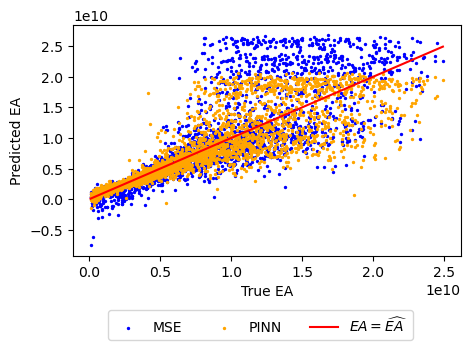

In [1]:
from dataset import DummyTrussDataset
from torch.utils.data import DataLoader
import mlflow
from mlflow.pytorch import load_model
from tools import MLFlowSession
import os
import numpy as np
import matplotlib.pyplot as plt

# Setup a memoire directory variable
memoire_dir = os.environ['memoire']
runs_dir = rf"{memoire_dir}/05-results/dummy"
device = 'mps'

server_mlp = MLFlowSession(PORT=6550, DIRECTORY=f"{runs_dir}/001", )
server_mlp.start(0)

server_hybrid = MLFlowSession(PORT=6555, DIRECTORY=f"{runs_dir}/005", )
server_hybrid.start(0)

fig, ax = plt.subplots(figsize=(5, 3))  # Wider figure for space

test_dataset_dir = r"../data/dataset/dummy_truss"
f = .05
validation_ds = DummyTrussDataset(
    f"{test_dataset_dir}/ood_val_512.hdf5",
    f_noise_loads=lambda size: np.random.normal(1, f / 2, size),
    f_noise_displacement=lambda size: np.random.normal(1, f / 2, size),
    f_noise_strain=lambda size: np.random.normal(1, f / 2, size)
)

# MSE based
mlflow.set_tracking_uri(uri=server_mlp.url())
dl = DataLoader(validation_ds, batch_size=8192)
experiment = mlflow.get_experiment_by_name("training2")
runs_df = mlflow.search_runs(experiment_ids=[experiment.experiment_id])
runs_df = runs_df[runs_df['params.loss'] == 'mse']

artifact_uri = runs_df[runs_df['params.train_size'] == '4096']['artifact_uri'].iloc[0]

uri = f"{artifact_uri}/input_scaler/"

input_scaler = load_model(uri)

uri = f"{artifact_uri}/target_scaler/"
target_scaler = load_model(uri)

uri = f"{artifact_uri}/mape_model/"
model = load_model(uri)

x, y, _, _, _, _ = dl.__iter__().__next__()

x = x.to(device)
y = y.to(device)

z_x = input_scaler.transform(x)
z_y = model(z_x)
y_pred = target_scaler.inverse_transform(z_y)
idx = np.arange(len(y_pred))
ax.scatter(y.detach().cpu()[idx, :], y_pred.detach().cpu()[idx, :], s=2, c='blue', label='MSE')
# PINN
mlflow.set_tracking_uri(uri=server_hybrid.url())
dl = DataLoader(validation_ds, batch_size=8192)
experiment = mlflow.get_experiment_by_name("training")
runs_df = mlflow.search_runs(experiment_ids=[experiment.experiment_id])
runs_df = runs_df[runs_df['params.loss'] == 'hybrid']
artifact_uri = runs_df[runs_df['params.train_size'] == '4096']['artifact_uri'].iloc[0]

uri = f"{artifact_uri}/input_scaler/"

input_scaler = load_model(uri)

uri = f"{artifact_uri}/target_scaler/"
target_scaler = load_model(uri)

uri = f"{artifact_uri}/mape_model/"
model = load_model(uri)

x, y, _, _, _, _ = dl.__iter__().__next__()

x = x.to(device)
y = y.to(device)

z_x = input_scaler.transform(x)
z_y = model(z_x)
y_pred = target_scaler.inverse_transform(z_y)

ax.scatter(y.detach().cpu()[idx, :], y_pred.detach().cpu()[idx, :], s=2, c='orange', label='PINN')
ax.plot([y.detach().cpu()[idx, :].min(), y.detach().cpu()[idx, :].max()],
        [y.detach().cpu()[idx, :].min(), y.detach().cpu()[idx, :].max()],
        color='r', linestyle="-", label=r'$EA = \widehat{EA}$')
ax.set_ylabel('Predicted EA', fontsize=10)
ax.set_xlabel('True EA', fontsize=10)
#ax.set_yscale('log')
#ax.set_xscale('log')
#ax.set_title('Comparison Between True and Predicted EA\nof MSE and PINN MLP on Out of Distribution Input', fontsize=12)
fig.legend(loc='upper center', bbox_to_anchor=(0.5, -.05), fontsize=10, ncols=3)
fig.savefig(r"img/03-out-of-distribution-parity-plot_size.pdf", bbox_inches='tight', transparent=True)
server_mlp.terminate()
server_hybrid.terminate()

MLflow server started at http://127.0.0.1:6550
Metadata database: /Users/aflamant/Documents/courses/2024-2025/mémoire/05-results/dummy/001/mlruns.db
Artifacts directory: /Users/aflamant/Documents/courses/2024-2025/mémoire/05-results/dummy/001
Workers: 4
Process group: 25844
MLflow server started at http://127.0.0.1:6555
Metadata database: /Users/aflamant/Documents/courses/2024-2025/mémoire/05-results/dummy/005/mlruns.db
Artifacts directory: /Users/aflamant/Documents/courses/2024-2025/mémoire/05-results/dummy/005
Workers: 4
Process group: 25845


Manim Community v0.19.0

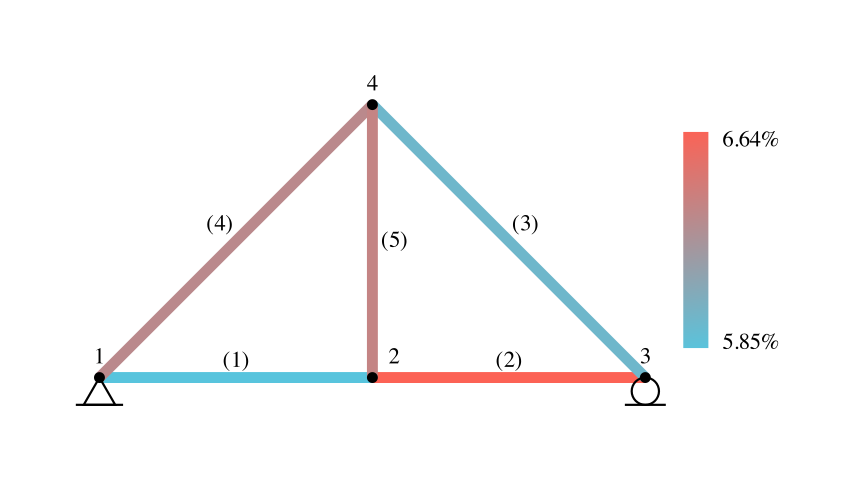

Manim Community v0.19.0

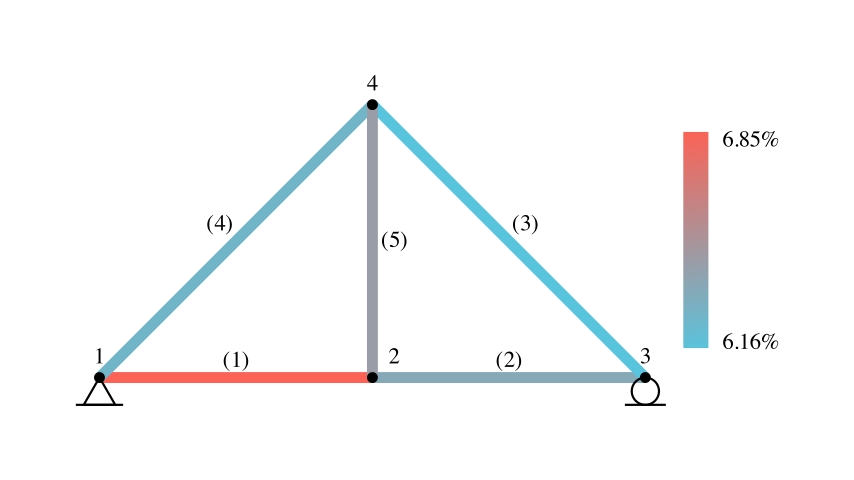

In [15]:
from dataset import DummyTrussDataset
from torch.utils.data import DataLoader
import mlflow
from mlflow.pytorch import load_model
from tools import MLFlowSession
import os
import numpy as np
import matplotlib.pyplot as plt

# Setup a memoire directory variable
memoire_dir = os.environ['memoire']
runs_dir = rf"{memoire_dir}/05-results/dummy"
device = 'mps'

server_mlp = MLFlowSession(PORT=6550, DIRECTORY=f"{runs_dir}/001", )
server_mlp.start(0)

server_hybrid = MLFlowSession(PORT=6555, DIRECTORY=f"{runs_dir}/005", )
server_hybrid.start(0)

test_dataset_dir = r"../data/dataset/dummy_truss"

validation_ds = DummyTrussDataset(f"{test_dataset_dir}/val_512.hdf5")
dl = DataLoader(validation_ds, batch_size=8192, shuffle=False)
_, y_exact, _, _, _, _ = dl.__iter__().__next__()
y_exact = y_exact.to(device)

f = .05
validation_ds = DummyTrussDataset(
    f"{test_dataset_dir}/val_512.hdf5",
    f_noise_loads=lambda size: np.random.normal(1, f / 2, size),
    f_noise_displacement=lambda size: np.random.normal(1, f / 2, size),
    f_noise_strain=lambda size: np.random.normal(1, f / 2, size)
)
dl = DataLoader(validation_ds, batch_size=8192, shuffle=False)
x, y, _, _, _, _ = dl.__iter__().__next__()

x = x.to(device)
y = y.to(device)

# MSE based
mlflow.set_tracking_uri(uri=server_mlp.url())
experiment = mlflow.get_experiment_by_name("training2")
runs_df = mlflow.search_runs(experiment_ids=[experiment.experiment_id])
runs_df = runs_df[runs_df['params.loss'] == 'mse']

artifact_uri = runs_df[runs_df['params.train_size'] == '4096']['artifact_uri'].iloc[0]

uri = f"{artifact_uri}/input_scaler/"

input_scaler = load_model(uri)

uri = f"{artifact_uri}/target_scaler/"
target_scaler = load_model(uri)

uri = f"{artifact_uri}/mape_model/"
model = load_model(uri)

z_x = input_scaler.transform(x)
z_y = model(z_x)
y_pred_mlp = target_scaler.inverse_transform(z_y)

# PINN
mlflow.set_tracking_uri(uri=server_hybrid.url())
experiment = mlflow.get_experiment_by_name("training")
runs_df = mlflow.search_runs(experiment_ids=[experiment.experiment_id])
runs_df = runs_df[runs_df['params.loss'] == 'hybrid']
artifact_uri = runs_df[runs_df['params.train_size'] == '4096']['artifact_uri'].iloc[0]

uri = f"{artifact_uri}/input_scaler/"

input_scaler = load_model(uri)

uri = f"{artifact_uri}/target_scaler/"
target_scaler = load_model(uri)

uri = f"{artifact_uri}/mape_model/"
model = load_model(uri)

z_x = input_scaler.transform(x)
z_y = model(z_x)
y_pred_hybrid = target_scaler.inverse_transform(z_y)

# Plot

mape_mlp = ((y_pred_mlp - y).abs() / y).mean(dim=0).detach().cpu().numpy()
mape_hybrid = ((y_pred_hybrid - y).abs() / y).mean(dim=0).detach().cpu().numpy()

server_mlp.terminate()
server_hybrid.terminate()


class ErrorRepartition(MovingCameraScene):
    def __init__(self, mape, name, **kargs):
        super().__init__(**kargs)
        self.mape = mape
        self.name = name
        self.camera.frame.scale(1.1)
        self.camera.frame.move_to(ORIGIN)

    def construct(self):
        nodes = np.array([(0, 0, 0), (5, 0, 0), (10, 0, 0), (5, 5, 0)], dtype=float)
        supports = {0: (True, True), 2: (False, True)}
        connectivity_matrix = np.array([(0, 1), (1, 2), (2, 3), (3, 0), (1, 3)])
        loads = {1: [0., -1000e3]}

        A = [.0025] * len(connectivity_matrix)
        E = [210.e9] * len(connectivity_matrix)

        font_size = 30
        g = Truss(nodes=nodes,
                  connectivity_matrix=connectivity_matrix,
                  supports=supports,
                  loads=loads,
                  support_style={'height': .5},
                  node_label_offsets=[.4 * UP, .4 * (UP + RIGHT), .4 * UP, .4 * UP],
                  member_label_offsets=[.3 * UP, .3 * UP, .3 * UR, .3 * UL, .4 * RIGHT],
                  load_labels=['1000kN'],
                  load_label_offsets=[1 * RIGHT],
                  load_label_style={'prefix': '\\textbf{', 'suffix': '}'},
                  tip_style={'tip_length': .45, 'tip_width': .3},
                  display_node_labels=True,
                  display_loads=False,
                  display_load_labels=False,
                  display_member_labels=True,
                  deformed_style={'dash_length': .15})

        g.move_to(ORIGIN)
        g.update()

        for member, mape in zip(g.members, self.mape):
            mape_min = self.mape.min()
            mape_max = self.mape.max()
            alpha = (mape - mape_min) / (mape_max - mape_min)
            color = interpolate_color(BLUE, RED, alpha)
            member.set(color=color, stroke_width=20)

        # Create a vertical rectangle
        grad = Rectangle(width=0.5, height=4)

        # Apply gradient from bottom (blue) to top (red)
        grad.set_fill(color=[BLUE, RED], opacity=1)

        grad.next_to(g, RIGHT, buff=.3)

        min_label = Text(f"{mape_min * 100:.3}%", color=BLACK, font_size=30).next_to(grad, RIGHT).align_to(grad, DOWN)
        max_label = Text(f"{mape_max * 100:.3}%", color=BLACK, font_size=30).next_to(grad, RIGHT).align_to(grad, UP)

        self.add(g, grad, min_label, max_label)

        all_group = get_all_vmobjects(self)
        all_group.center()
        path = f"img/03-{self.name}-mape-repartition.svg"
        all_group.to_svg(path, crop=True)


class MSEErrorRepartition(ErrorRepartition):
    def __init__(self, **kargs):
        super().__init__(mape_mlp, 'mse', **kargs)


class PINNErrorRepartition(ErrorRepartition):
    def __init__(self, **kargs):
        super().__init__(mape_hybrid, 'pinn', **kargs)

%manim --format png -ql -v WARNING MSEErrorRepartition
%manim --format png -ql -v WARNING PINNErrorRepartition

np.float32(0.06310315)

In [35]:
mlflow.set_tracking_uri(uri=server_mlp.url())
dl = DataLoader(validation_ds, batch_size=8192)
experiment = mlflow.get_experiment_by_name("training2")
runs_df = mlflow.search_runs(experiment_ids=[experiment.experiment_id])

tensor([0.3148, 0.2753, 0.2743, 0.2613, 0.3024], device='mps:0',
       grad_fn=<MeanBackward1>)